In [0]:
# Use Spark DataFrame for large data exploration
# This will load the complete table as a Spark DataFrame (distributed, scalable)
df_raw = spark.table("dl_tenants_daas.us_wealth_management.wealth_management_client_metrics")
display(df_raw.count())

382870179

In [0]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# Compute average psn_age for each axa_party_id across all business_months
w_party = Window.partitionBy("axa_party_id")
df_raw = df_raw.withColumn("avg_psn_age", F.avg("psn_age").over(w_party))

# Replace psn_age with the averaged value
df_raw = df_raw.withColumn("psn_age", F.col("avg_psn_age")).drop("avg_psn_age")

# Remove duplicate policy_no for each axa_party_id
df_raw = df_raw.dropDuplicates(["axa_party_id","policy_no"])
display(df_raw.count())

10662722

In [0]:
from pyspark.sql import functions as F, Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from pyspark.sql.functions import concat_ws

# ------------- PARAMETERS -------------
SAMPLE_FRACTION = 1   # set None to use full data
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1
TEST_FRAC = 0.1
RANDOM_SEED = 42

# LightGBM training params
LGB_PARAMS = {
    "objective": "multiclass",
    "num_class": 6,               # will be set dynamically
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "lambda_l2": 2.0,
    "verbosity": -1
}
NUM_BOOST_ROUND = 2000
EARLY_STOP = 50

# ------------- 1) Create product_category -------------
df_raw = df_raw.withColumn(
    "product_category",
    F.when(F.col("prod_lob") == "LIFE", "LIFE_INSURANCE")
    .when(F.col("sub_product_level_1").isin("VLI", "WL", "UL/IUL", "TERM", "PROTECTIVE PRODUCT"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").like("%LIFE%"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").isin(
        "VARIABLE UNIVERSAL LIFE", "WHOLE LIFE", "UNIVERSAL LIFE",
        "INDEX UNIVERSAL LIFE", "TERM PRODUCT", "VARIABLE LIFE",
        "SURVIVORSHIP WHOLE LIFE", "MONY PROTECTIVE PRODUCT"
    ), "LIFE_INSURANCE")
    .when(F.col("prod_lob").isin("GROUP RETIREMENT", "INDIVIDUAL RETIREMENT"), "RETIREMENT")
    .when(F.col("sub_product_level_1").isin(
        "EQUIVEST", "RETIREMENT 401K", "ACCUMULATOR",
        "RETIREMENT CORNERSTONE", "SCS", "INVESTMENT EDGE"
    ), "RETIREMENT")
    .when(
        (F.col("sub_product_level_2").like("%403B%")) |
        (F.col("sub_product_level_2").like("%401%")) |
        (F.col("sub_product_level_2").like("%IRA%")) |
        (F.col("sub_product_level_2").like("%SEP%")),
        "RETIREMENT"
    )
    .when(F.col("prod_lob") == "BROKER DEALER", "INVESTMENT")
    .when(F.col("sub_product_level_1").isin(
        "INVESTMENT PRODUCT - DIRECT", "INVESTMENT PRODUCT - BROKERAGE",
        "INVESTMENT PRODUCT - ADVISORY", "DIRECT", "BROKERAGE",
        "ADVISORY", "CASH SOLICITOR"
    ), "INVESTMENT")
    .when(
        (F.col("sub_product_level_2").like("%Investment%")) |
        (F.col("sub_product_level_2").like("%Brokerage%")) |
        (F.col("sub_product_level_2").like("%Advisory%")),
        "INVESTMENT"
    )
    .when(F.col("prod_lob") == "NETWORK", "NETWORK_PRODUCTS")
    .when(
        (F.col("sub_product_level_1") == "NETWORK PRODUCTS") |
        (F.col("sub_product_level_2") == "NETWORK PRODUCTS"),
        "NETWORK_PRODUCTS"
    )
    .when(
        (F.col("prod_lob") == "OTHERS") & (F.col("sub_product_level_1") == "HAS"),
        "DISABILITY"
    )
    .when(F.col("sub_product_level_2") == "HAS - DISABILITY", "DISABILITY")
    .when(F.col("prod_lob") == "OTHERS", "HEALTH")
    .when(F.col("sub_product_level_2") == "GROUP HEALTH PRODUCTS", "HEALTH")
    .otherwise("OTHER")
)

# ------------- 2) Filter and prepare events -------------
df_events = df_raw.select(
    "axa_party_id", "product_category", "register_date", "isrd_brth_date",
    "acct_val_amt", "face_amt", "cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age", "client_seg", "client_seg_1", "aum_band", "channel", "agent_segment",
    "branchoffice_code", "policy_status"
).filter(
    (F.col("axa_party_id").isNotNull()) &
    (F.col("register_date").isNotNull()) &
    (F.col("product_category").isNotNull()) &
    (F.col("policy_status") == "Active")
)

if SAMPLE_FRACTION is not None:
    print("Sampling fraction:", SAMPLE_FRACTION)
    df_events = df_events.sample(withReplacement=False, fraction=float(SAMPLE_FRACTION), seed=RANDOM_SEED)

print("Event rows (approx):", df_events.count())

# ------------- 3) Convert dates and order events per client -------------
df_events = df_events.withColumn("register_ts", F.to_timestamp("register_date"))
df_events = df_events.withColumn("birth_ts", F.to_timestamp("isrd_brth_date"))

w = Window.partitionBy("axa_party_id").orderBy(F.col("register_ts").asc())
df_events = df_events.withColumn("event_idx", F.row_number().over(w))

# ------------- 4) Filter to clients with 2+ policies -------------
w_count = Window.partitionBy("axa_party_id")
df_events = df_events.withColumn("total_policies", F.count("*").over(w_count))
df_events_multi = df_events.filter(F.col("total_policies") >= 2)
print("Clients with 2+ policies (rows):", df_events_multi.count())

# ------------- 5) Get last and last-but-one policy per client -------------
w_desc = Window.partitionBy("axa_party_id").orderBy(F.col("register_ts").desc())

df_events_multi = df_events_multi.withColumn("reverse_event_idx", F.row_number().over(w_desc))

# Last policy (reverse_event_idx == 1)
df_last = df_events_multi.filter(F.col("reverse_event_idx") == 1).select(
    F.col("axa_party_id"),
    F.col("product_category").alias("second_product_category"),
    F.col("register_ts").alias("second_register_ts")
)

# Last but one policy (reverse_event_idx == 2)
df_last_but_one = df_events_multi.filter(F.col("reverse_event_idx") == 2).select(
    F.col("axa_party_id"),
    F.col("product_category").alias("first_product_category"),
    F.col("register_ts").alias("first_register_ts"),
    F.col("birth_ts"),
    F.col("acct_val_amt").alias("first_acct_val_amt"),
    F.col("face_amt").alias("first_face_amt"),
    F.col("cash_val_amt").alias("first_cash_val_amt"),
    F.col("wc_total_assets"),
    F.col("wc_assetmix_stocks"),
    F.col("wc_assetmix_bonds"),
    F.col("wc_assetmix_mutual_funds"),
    F.col("wc_assetmix_annuity"),
    F.col("wc_assetmix_deposits"),
    F.col("wc_assetmix_other_assets"),
    F.col("psn_age"),
    F.col("client_seg"),
    F.col("client_seg_1"),
    F.col("aum_band"),
    F.col("channel"),
    F.col("agent_segment"),
    F.col("branchoffice_code")
)

# ------------- 6) Join last-but-one and last policy on axa_party_id -------------
df_combined = df_last_but_one.join(df_last, on="axa_party_id", how="inner")
print("Clients with both last and last-but-one policy:", df_combined.count())

############ Save the training data to the table
df_combined.write.mode("overwrite").option("mergeSchema", "true").saveAsTable("eda_smartlist.us_wealth_management_smartlist.Smartlist_ML_training_data")
############

# ------------- 7) Add NEW FEATURES -------------

df_combined = df_combined.withColumn(
    "stock_allocation_ratio",
    F.col("wc_assetmix_stocks") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_combined = df_combined.withColumn(
    "bond_allocation_ratio",
    F.col("wc_assetmix_bonds") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_combined = df_combined.withColumn(
    "annuity_allocation_ratio",
    F.col("wc_assetmix_annuity") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_combined = df_combined.withColumn(
    "mutual_fund_allocation_ratio",
    F.col("wc_assetmix_mutual_funds") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)

df_combined = df_combined.withColumn(
    "season_of_first_policy",
    F.when(F.month("first_register_ts").between(1, 3), "Q1")
    .when(F.month("first_register_ts").between(4, 6), "Q2")
    .when(F.month("first_register_ts").between(7, 9), "Q3")
    .when(F.month("first_register_ts").between(10, 12), "Q4")
    .otherwise("Unknown")
)

df_combined = df_combined.withColumn(
    "age_at_first_policy",
    F.datediff(F.col("first_register_ts"), F.col("birth_ts")) / 365.25
)

df_combined = df_combined.withColumn(
    "years_to_second_policy",
    F.datediff(F.col("second_register_ts"), F.col("first_register_ts")) / 365.25
)

# ------------- 8) Build product vocabulary for SECOND product (target) -------------
prod_list = df_combined.select("second_product_category").distinct().rdd.map(lambda r: r[0]).collect()
prod_list = sorted([p for p in prod_list if p is not None])
prod2id = {p: i for i, p in enumerate(prod_list)}   # 0-indexed labels
id2prod = {v: k for k, v in prod2id.items()}
NUM_CLASSES = len(prod2id)
print("Vocabulary size (classes for second product):", NUM_CLASSES)
LGB_PARAMS["num_class"] = NUM_CLASSES

df_combined = df_combined.withColumn(
    "label",
    F.when(F.col("second_product_category").isNotNull(), 
           F.udf(lambda x: prod2id.get(x, 0), IntegerType())(F.col("second_product_category")))
    .otherwise(0)
)

# ------------- 9) Fill missing values with median for numeric columns -------------
numeric_cols = [
    "first_acct_val_amt", "first_face_amt", "first_cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age", "stock_allocation_ratio", "bond_allocation_ratio",
    "annuity_allocation_ratio", "mutual_fund_allocation_ratio",
    "age_at_first_policy", "years_to_second_policy"
]

# Compute medians for numeric columns
medians = df_combined.select([
    F.expr(f"percentile_approx({col}, 0.5)") for col in numeric_cols
]).first()
median_dict = {col: medians[i] for i, col in enumerate(numeric_cols)}

# Fill nulls with median for numeric columns
for c in numeric_cols:
    df_combined = df_combined.withColumn(
        c, F.when(F.col(c).isNull(), F.lit(median_dict[c])).otherwise(F.col(c))
    )

categorical_cols = ["first_product_category", "client_seg", "client_seg_1", "aum_band", 
                    "channel", "agent_segment", "branchoffice_code", "season_of_first_policy"]
modes = {}
for c in categorical_cols:
    try:
        m = df_combined.groupBy(c).count().orderBy(F.desc("count")).first()[0]
        modes[c] = m if m is not None else "UNKNOWN"
    except:
        modes[c] = "UNKNOWN"

for c in categorical_cols:
    df_combined = df_combined.withColumn(
        c, F.when(F.col(c).isNull(), F.lit(modes[c])).otherwise(F.col(c))
    )

# ------------- 10) Encode categorical features -------------
for c in categorical_cols:
    vals = [r[0] for r in df_combined.select(c).distinct().collect()]
    m = {str(v): i for i, v in enumerate(sorted([str(x) for x in vals]))}
    b = spark.sparkContext.broadcast(m)
    df_combined = df_combined.withColumn(
        c + "_idx",
        F.udf(lambda s: int(b.value.get(str(s), 0)), IntegerType())(F.coalesce(F.col(c).cast("string"), F.lit("UNKNOWN")))
    )

# ------------- 11) Define model feature columns -------------
model_feature_cols = [
    "first_acct_val_amt", "first_face_amt", "first_cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age",
    "stock_allocation_ratio", "bond_allocation_ratio",
    "annuity_allocation_ratio", "mutual_fund_allocation_ratio",
    "age_at_first_policy", "years_to_second_policy",
    "first_product_category_idx", "client_seg_idx", "client_seg_1_idx", "aum_band_idx",
    "channel_idx", "agent_segment_idx", "branchoffice_code_idx", "season_of_first_policy_idx"
]

# ------------- 12) Split train/val/test and convert to Pandas -------------
train_spark, val_spark, test_spark = df_combined.randomSplit([TRAIN_FRAC, VAL_FRAC, TEST_FRAC], seed=RANDOM_SEED)

print("Train / Val / Test counts:", train_spark.count(), val_spark.count(), test_spark.count())

train_spark = train_spark.cache()
val_spark = val_spark.cache()
test_spark = test_spark.cache()

train_pd = train_spark.select(["axa_party_id", "label"] + model_feature_cols).toPandas()
val_pd = val_spark.select(["axa_party_id", "label"] + model_feature_cols).toPandas()
test_pd = test_spark.select(["axa_party_id", "label"] + model_feature_cols).toPandas()

# ------------- 13) Final data sanity -------------
train_pd.fillna(0, inplace=True)
val_pd.fillna(0, inplace=True)
test_pd.fillna(0, inplace=True)

print("\n=== FINAL DATA SUMMARY ===")
print("Num classes (second products):", NUM_CLASSES)
print("Train shape:", train_pd.shape, "Val shape:", val_pd.shape, "Test shape:", test_pd.shape)
print("Feature columns:", len(model_feature_cols))
print("\nYears to second policy stats:")
print("  Mean:", train_pd['years_to_second_policy'].mean())
print("  Median:", train_pd['years_to_second_policy'].median())
print("  Min:", train_pd['years_to_second_policy'].min())
print("  Max:", train_pd['years_to_second_policy'].max())
print("\nSample training data:")
display(train_pd.head(10))

Sampling fraction: 1
Event rows (approx): 6493231
Clients with 2+ policies (rows): 3483016
Clients with both last and last-but-one policy: 1095923
Vocabulary size (classes for second product): 7
Train / Val / Test counts: 876313 109431 109518

=== FINAL DATA SUMMARY ===
Num classes (second products): 7
Train shape: (875645, 27) Val shape: (109458, 27) Test shape: (109515, 27)
Feature columns: 25

Years to second policy stats:
  Mean: 6.341903027977787
  Median: 1.9247091033538672
  Min: -14.302532511978097
  Max: 8014.2340862423

Sample training data:


axa_party_id,label,first_acct_val_amt,first_face_amt,first_cash_val_amt,wc_total_assets,wc_assetmix_stocks,wc_assetmix_bonds,wc_assetmix_mutual_funds,wc_assetmix_annuity,wc_assetmix_deposits,wc_assetmix_other_assets,psn_age,stock_allocation_ratio,bond_allocation_ratio,annuity_allocation_ratio,mutual_fund_allocation_ratio,age_at_first_policy,years_to_second_policy,first_product_category_idx,client_seg_idx,client_seg_1_idx,aum_band_idx,channel_idx,agent_segment_idx,branchoffice_code_idx,season_of_first_policy_idx
00BK05RY27QPLN0IXXXX,6,924.0,1000.0,924.0,365227.0,23031.0,666.0,97070.0,11606.0,232331.0,523.0,83.4,0.06305941236546038,0.0018235234525377367,0.031777497282511974,0.2657799122189761,7.819301848049282,56.903490759753595,3,1,10,3,3,0,17,1
00BK05RY2PTJH86EXXXX,4,17028.609375,100000.0,17028.609375,3364441.0,1551272.0,227289.0,1251939.0,25252.0,273638.0,35051.0,77.33980582524272,0.46107867547684744,0.06755624485612914,0.007505555900668194,0.3721090665581593,60.492813141683776,3.9425051334702257,3,2,8,3,3,2,29,1
00BK05RY2ROFGCK0XXXX,3,53558.0,103553.0,53558.0,412394.0,62189.0,2147.0,50683.0,7851.0,286100.0,3424.0,65.16666666666667,0.15079996314204377,0.0052061863169687245,0.019037619364006265,0.12289946022493052,44.492813141683776,1.45927446954141,3,3,8,2,3,0,11,2
00BK05RY3VVCXRD6XXXX,6,115220.2578125,50000.0,0.0,1565309.0,398037.0,9490.0,877959.0,60784.0,207865.0,11174.0,67.68896321070234,0.25428653384092215,0.006062700719155132,0.0388319494745127,0.560885422622626,42.48049281314169,0.019164955509924708,2,0,8,0,3,1,59,0
00BK05RY4J2HJ55BXXXX,2,4340.02978515625,250000.0,4340.02978515625,1300376.0,342848.0,16147.0,502823.0,48530.0,355696.0,34332.0,61.93457943925234,0.2636529742166881,0.012417177800882206,0.037319975145650185,0.38667508474472,32.238193018480494,20.15605749486653,3,0,12,3,3,0,58,1
00BK05RY4RZ18S4BXXXX,2,19084.970703125,50000.0,0.0,2553444.0,1402741.0,2844.0,790911.0,22149.0,313613.0,21186.0,29.22222222222222,0.5493525606984135,0.0011137898461842123,0.00867416712487135,0.30974284143298225,42.48049281314169,0.0,2,0,3,3,3,0,36,3
00BK05RY4X9FOPHOXXXX,2,2154.639892578125,2154.639892578125,0.0,7580204.0,3651264.0,399782.0,2294054.0,52587.0,961445.0,221072.0,72.64497041420118,0.48168413409454414,0.05274026925924421,0.006937412238509676,0.30263750157647473,42.48049281314169,15.419575633127995,2,4,3,3,3,0,51,1
00BK05RY505YIXJHXXXX,3,1398.1300048828125,100000.0,1398.1300048828125,33714.0,1162.0,0.0,921.0,277.0,31263.0,91.0,47.92857142857143,0.034466393782998164,0.0,0.008216171323485792,0.027318028118882363,27.57015742642026,6.921286789869952,3,5,4,3,1,0,102,2
00BK05RY526LB7EXXXXX,3,34607.2890625,34607.2890625,0.0,806947.0,216922.0,14531.0,235327.0,57492.0,273081.0,9594.0,44.43333333333333,0.2688181503865805,0.018007378427579507,0.07124631481373622,0.29162633977200486,28.67898699520876,2.4750171115674195,6,3,13,1,3,2,96,0
00BK05RY5599I066XXXX,2,135551.71875,135551.71875,0.0,4688867.0,2080055.0,188459.0,1655601.0,33148.0,583886.0,147718.0,55.30232558139535,0.4436156964998154,0.04019286535531931,0.007069511675208531,0.35309190898355614,42.48049281314169,4.542094455852156,2,2,12,0,3,2,94,3


In [0]:
# ------------- 15) LightGBM training -------------
import numpy as np

feature_cols_final = model_feature_cols  # order as defined
train_ds = lgb.Dataset(train_pd[feature_cols_final], label=train_pd["label"])
val_ds = lgb.Dataset(val_pd[feature_cols_final], label=val_pd["label"], reference=train_ds)

model = lgb.train(
    LGB_PARAMS,
    train_ds,
    valid_sets=[train_ds, val_ds],
    valid_names=["train","val"],
    num_boost_round=NUM_BOOST_ROUND,
    callbacks=[lgb.early_stopping(50)]
)

# ------------- 16) Evaluation -------------
test_pred_prob = model.predict(test_pd[feature_cols_final])
test_pred = np.argmax(test_pred_prob, axis=1)

acc = accuracy_score(test_pd["label"], test_pred)
f1_weighted = f1_score(test_pd["label"], test_pred, average="weighted")
f1_macro = f1_score(test_pd["label"], test_pred, average="macro")
print("Test Accuracy:", acc)
print("Test F1 weighted:", f1_weighted)
print("Test F1 macro:", f1_macro)
print("Classification report:")
print(classification_report(test_pd["label"], test_pred))

cm = confusion_matrix(test_pd["label"], test_pred)
print("Confusion matrix shape:", cm.shape)

print("Done.")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's multi_logloss: 0.446388	val's multi_logloss: 0.500196


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test Accuracy: 0.8135963110076245
Test F1 weighted: 0.8052068165593971
Test F1 macro: 0.7488424817423466
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       247
           1       1.00      0.81      0.90        16
           2       0.83      0.95      0.88     55909
           3       0.78      0.77      0.77     18550
           4       0.81      0.51      0.63      8233
           5       0.90      0.32      0.47      1845
           6       0.80      0.68      0.74     24715

    accuracy                           0.81    109515
   macro avg       0.86      0.69      0.75    109515
weighted avg       0.81      0.81      0.81    109515

Confusion matrix shape: (7, 7)
Done.


In [0]:
# import mlflow
# import mlflow.lightgbm
# from mlflow.models import infer_signature

# # Use train_pd and model from previous cells
# input_example = train_pd[feature_cols_final].iloc[:5]
# output_example = model.predict(input_example)
# signature = infer_signature(input_example, output_example)

# with mlflow.start_run():
#     mlflow.lightgbm.log_model(
#         model,
#         artifact_path="lgbm_model_020226",
#         registered_model_name="eda_smartlist.models.lgbm_model_020226",
#         signature=signature,
#         input_example=input_example
#     )

# # register and create an alias

# from mlflow import MlflowClient

# client = MlflowClient()
# model_name = "eda_smartlist.models.lgbm_model_020226"
# model_version = "1"  
# alias = "lgbm1"

# client.set_registered_model_alias(
#     name=model_name,
#     alias=alias,
#     version=model_version
# )

Starting hyperparameter tuning with Optuna...
Number of trials: 50
Optimization metric: F1-weighted score



[I 2026-02-16 11:13:57,878] A new study created in memory with name: lgbm_product_prediction


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2026-02-16 11:17:39,432] Trial 0 finished with value: 0.8080512908158985 and parameters: {'learning_rate': 0.023688639503640783, 'num_leaves': 123, 'min_data_in_leaf': 79, 'feature_fraction': 0.8394633936788146, 'subsample': 0.6624074561769746, 'lambda_l2': 0.2051110418843398}. Best is trial 0 with value: 0.8080512908158985.
[I 2026-02-16 11:21:40,641] Trial 1 finished with value: 0.7796271501522474 and parameters: {'learning_rate': 0.011430983876313222, 'num_leaves': 115, 'min_data_in_leaf': 68, 'feature_fraction': 0.8832290311184181, 'subsample': 0.608233797718321, 'lambda_l2': 8.706020878304859}. Best is trial 0 with value: 0.8080512908158985.
[I 2026-02-16 11:25:01,360] Trial 2 finished with value: 0.8105791730852023 and parameters: {'learning_rate': 0.06798962421591129, 'num_leaves': 51, 'min_data_in_leaf': 34, 'feature_fraction': 0.6733618039413735, 'subsample': 0.7216968971838151, 'lambda_l2': 1.1207606211860568}. Best is trial 2 with value: 0.8105791730852023.
[I 2026-02-16 

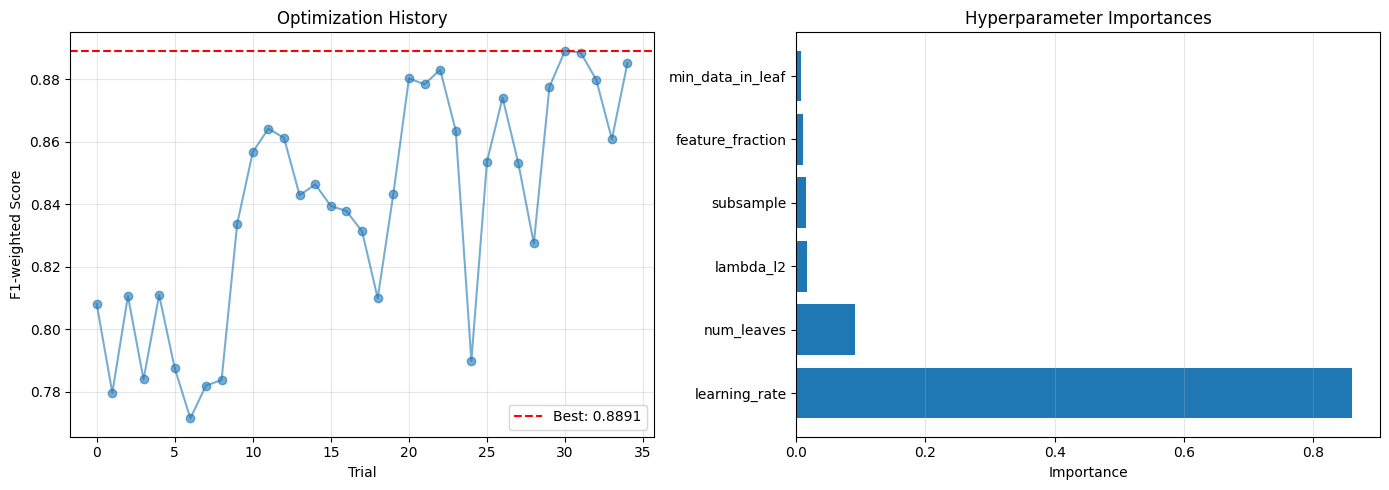


Hyperparameter tuning completed!


In [0]:
# ============================================
# HYPERPARAMETER TUNING WITH OPTUNA
# ============================================

import optuna
import mlflow
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score

# Set MLflow experiment
mlflow.set_experiment("/Users/rajesh.patil@equitable.com/lgbm_hyperparameter_tuning")

def objective(trial):
    """
    Optuna objective function for LightGBM hyperparameter tuning.
    """
    # Suggest hyperparameters
    params = {
        "objective": "multiclass",
        "num_class": NUM_CLASSES,
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "subsample_freq": 1,
        "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 10.0, log=True),
        "verbosity": -1,
        "random_state": 42
    }
    
    # Create fresh Dataset objects for this trial
    train_ds_trial = lgb.Dataset(train_pd[feature_cols_final], label=train_pd["label"], params={"feature_pre_filter": False})
    val_ds_trial = lgb.Dataset(val_pd[feature_cols_final], label=val_pd["label"], reference=train_ds_trial, params={"feature_pre_filter": False})
    
    # Start MLflow run
    with mlflow.start_run(nested=True):
        # Log parameters
        mlflow.log_params(params)
        
        # Train model with early stopping
        model = lgb.train(
            params,
            train_ds_trial,
            num_boost_round=2000,
            valid_sets=[val_ds_trial],
            valid_names=["valid_0"],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False)
            ]
        )
        
        # Predict on validation set
        val_preds_proba = model.predict(val_pd[feature_cols_final])
        val_preds = np.argmax(val_preds_proba, axis=1)
        
        # Calculate F1 score (weighted)
        f1_weighted = f1_score(val_pd["label"], val_preds, average="weighted")
        
        # Log metrics
        mlflow.log_metric("f1_weighted", f1_weighted)
        mlflow.log_metric("best_iteration", model.best_iteration)
        
    return f1_weighted

# Create Optuna study
print("Starting hyperparameter tuning with Optuna...")
print(f"Number of trials: 50")
print(f"Optimization metric: F1-weighted score\n")

with mlflow.start_run(run_name="optuna_hyperparameter_tuning"):
    study = optuna.create_study(
        direction="maximize",
        study_name="lgbm_product_prediction",
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=35, show_progress_bar=True)
    
    # Log best parameters and score
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING RESULTS")
    print("="*60)
    print(f"\nBest F1-weighted score: {study.best_value:.4f}")
    print(f"\nBest hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
        mlflow.log_param(f"best_{key}", value)
    
    mlflow.log_metric("best_f1_weighted", study.best_value)
    
    # Create optimization history plot
    try:
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot optimization history
        trials_df = study.trials_dataframe()
        ax1.plot(trials_df["number"], trials_df["value"], marker="o", alpha=0.6)
        ax1.axhline(y=study.best_value, color="r", linestyle="--", label=f"Best: {study.best_value:.4f}")
        ax1.set_xlabel("Trial")
        ax1.set_ylabel("F1-weighted Score")
        ax1.set_title("Optimization History")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter importances
        try:
            importances = optuna.importance.get_param_importances(study)
            params_sorted = sorted(importances.items(), key=lambda x: x[1], reverse=True)
            param_names = [p[0] for p in params_sorted]
            param_values = [p[1] for p in params_sorted]
            
            ax2.barh(param_names, param_values)
            ax2.set_xlabel("Importance")
            ax2.set_title("Hyperparameter Importances")
            ax2.grid(True, alpha=0.3, axis="x")
        except:
            ax2.text(0.5, 0.5, "Not enough trials\nfor importance analysis", 
                    ha="center", va="center", transform=ax2.transAxes)
        
        plt.tight_layout()
        mlflow.log_figure(fig, "optimization_history.png")
        plt.show()
    except Exception as e:
        print(f"\nNote: Could not create visualization: {e}")

print("\n" + "="*60)
print("Hyperparameter tuning completed!")
print("="*60)

In [0]:
# ============================================
# SAVE BEST MODEL FROM HYPERPARAMETER TUNING
# ============================================

import mlflow
import mlflow.lightgbm
from mlflow.models import infer_signature
import lightgbm as lgb
import numpy as np

print("="*60)
print("SAVING BEST MODEL FROM HYPERPARAMETER TUNING")
print("="*60)
print(f"\nBest F1-weighted score: {study.best_value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Build final model parameters with best hyperparameters
final_params = {
    "objective": "multiclass",
    "num_class": NUM_CLASSES,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "random_state": 42
}
final_params.update(study.best_params)

# Create datasets
train_ds_final = lgb.Dataset(train_pd[feature_cols_final], label=train_pd["label"], params={"feature_pre_filter": False})
val_ds_final = lgb.Dataset(val_pd[feature_cols_final], label=val_pd["label"], reference=train_ds_final, params={"feature_pre_filter": False})

# Train final model with best hyperparameters
print("\nTraining final model with best parameters...")
best_model = lgb.train(
    final_params,
    train_ds_final,
    num_boost_round=2000,
    valid_sets=[val_ds_final],
    valid_names=["valid_0"],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

print(f"Training complete! Best iteration: {best_model.best_iteration}")

# Prepare signature
input_example = train_pd[feature_cols_final].iloc[:5]
output_example = best_model.predict(input_example)
signature = infer_signature(input_example, output_example)

# Log and register model to Unity Catalog
print("\nRegistering model to Unity Catalog...")

with mlflow.start_run():
    mlflow.lightgbm.log_model(
        best_model,
        artifact_path="lgbm_model_hyperparameter_axa_fulldata_last2products",
        registered_model_name="eda_smartlist.models.lgbm_model_hyperparameter_axa_fulldata_last2products",
        signature=signature,
        input_example=input_example
    )

print("\n" + "="*60)
print("✓ MODEL SAVED SUCCESSFULLY!")
print("="*60)
print(f"Model name: eda_smartlist.models.lgbm_model_hyperparameter_axa_fulldata_last2products")
print("="*60)

SAVING BEST MODEL FROM HYPERPARAMETER TUNING

Best F1-weighted score: 0.8891

Best hyperparameters:
  learning_rate: 0.0998374493434458
  num_leaves: 115
  min_data_in_leaf: 41
  feature_fraction: 0.765836702637975
  subsample: 0.8135599264786633
  lambda_l2: 0.14806432551904528

Training final model with best parameters...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Training complete! Best iteration: 2000

Registering model to Unity Catalog...


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Registered model 'eda_smartlist.models.lgbm_model_hyperparameter_axa_fulldata_last2products' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]


✓ MODEL SAVED SUCCESSFULLY!
Model name: eda_smartlist.models.lgbm_model_hyperparameter_axa_fulldata_last2products


Created version '2' of model 'eda_smartlist.models.lgbm_model_hyperparameter_axa_fulldata_last2products'.


BEST MODEL EVALUATION ON TEST SET

Test Set Performance:
  Accuracy:      0.8814
  F1 Weighted:   0.8789
  F1 Macro:      0.8520
  Best Iteration: 2000

Comparison with Optuna Validation F1:
  Optuna Best F1 (validation): 0.8891
  Test F1 (weighted):          0.8789
  Difference:                  -0.0102

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

      DISABILITY       0.90      0.80      0.84       247
          HEALTH       1.00      0.88      0.93        16
      INVESTMENT       0.88      0.97      0.92     55909
  LIFE_INSURANCE       0.87      0.85      0.86     18550
NETWORK_PRODUCTS       0.87      0.71      0.78      8233
           OTHER       0.98      0.66      0.79      1845
      RETIREMENT       0.89      0.79      0.83     24715

        accuracy                           0.88    109515
       macro avg       0.91      0.81      0.85    109515
    weighted avg       0.88      0.88      0.88    109515


CONFUSION MATRIX


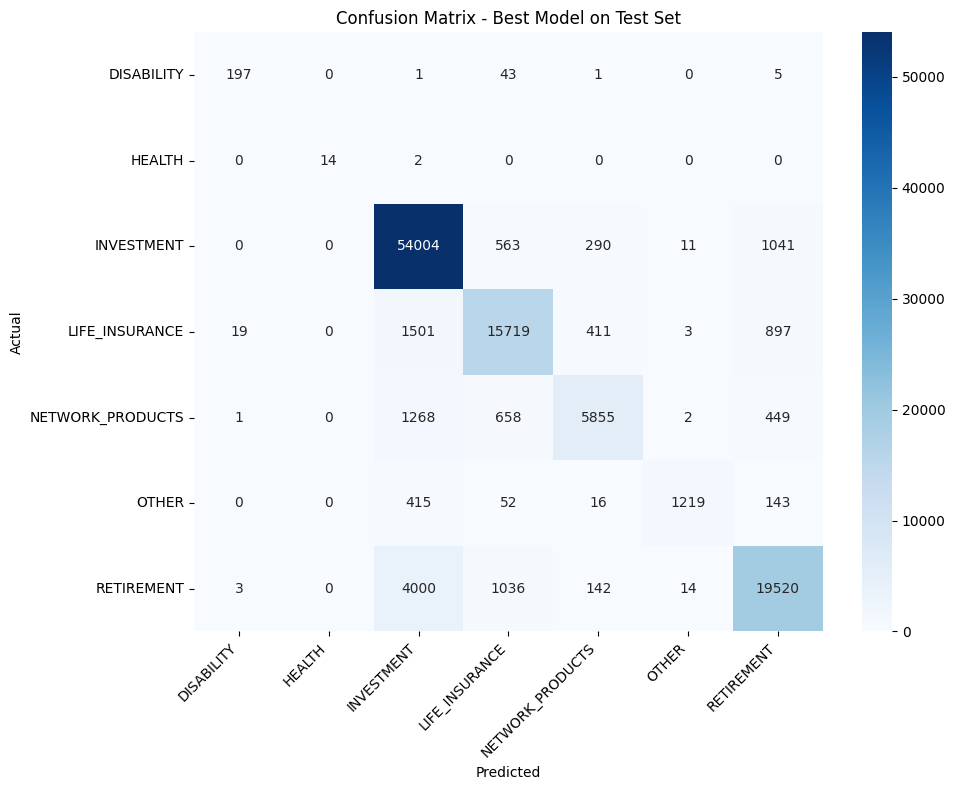


VERIFICATION COMPLETE


In [0]:
# ============================================
# VERIFY BEST MODEL PERFORMANCE
# ============================================

import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("BEST MODEL EVALUATION ON TEST SET")
print("="*60)

# Predict on test set
test_pred_prob = best_model.predict(test_pd[feature_cols_final])
test_pred = np.argmax(test_pred_prob, axis=1)

# Calculate metrics
test_acc = accuracy_score(test_pd["label"], test_pred)
test_f1_weighted = f1_score(test_pd["label"], test_pred, average="weighted")
test_f1_macro = f1_score(test_pd["label"], test_pred, average="macro")

print(f"\nTest Set Performance:")
print(f"  Accuracy:      {test_acc:.4f}")
print(f"  F1 Weighted:   {test_f1_weighted:.4f}")
print(f"  F1 Macro:      {test_f1_macro:.4f}")
print(f"  Best Iteration: {best_model.best_iteration}")

print(f"\nComparison with Optuna Validation F1:")
print(f"  Optuna Best F1 (validation): {study.best_value:.4f}")
print(f"  Test F1 (weighted):          {test_f1_weighted:.4f}")
print(f"  Difference:                  {test_f1_weighted - study.best_value:.4f}")

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(test_pd["label"], test_pred, target_names=[id2prod[i] for i in range(NUM_CLASSES)]))

# Confusion matrix
cm = confusion_matrix(test_pd["label"], test_pred)
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2prod[i] for i in range(NUM_CLASSES)],
            yticklabels=[id2prod[i] for i in range(NUM_CLASSES)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Model on Test Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VERIFICATION COMPLETE")
print("="*60)

feature,importance
first_product_category_idx,2370618.1106267893
age_at_first_policy,1292972.8194494112
years_to_second_policy,1252365.54092547
psn_age,613135.9620766204
branchoffice_code_idx,590352.9761513773
first_acct_val_amt,538706.2763486238
first_face_amt,530827.1716923324
annuity_allocation_ratio,302763.00922330766
first_cash_val_amt,278000.1578219529
wc_assetmix_deposits,259261.7481375442


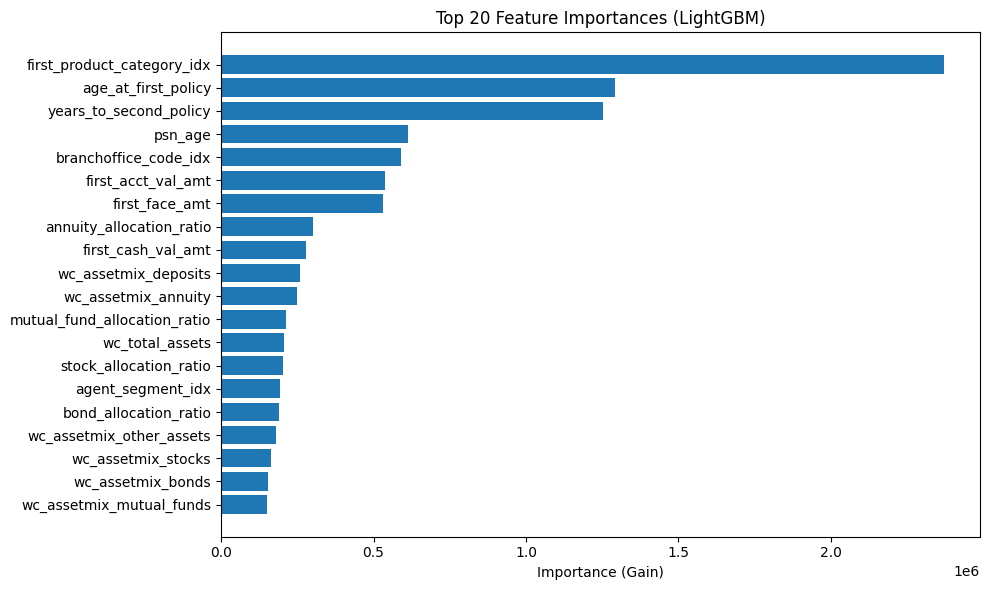

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the trained LightGBM model
feature_importances = best_model.feature_importance(importance_type='gain')
feature_names = feature_cols_final

# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Display top 20 features
display(feat_imp_df.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df.head(20)['feature'][::-1], feat_imp_df.head(20)['importance'][::-1])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.tight_layout()
plt.show()

In [0]:
# ============================================
# PREDICTIONS FOR BRANCH OFFICE 83 - MOST RECENT BUSINESS_MONTH
# For axa_party_id with only ONE policy (policy_no)
# Using feature logic from cell 4 exactly
# ============================================

from pyspark.sql import functions as F, Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import numpy as np
import pandas as pd
import mlflow
import mlflow.lightgbm

# ------------- 1) Load model from MLflow -------------
print("Loading model from MLflow...")
model = mlflow.lightgbm.load_model("models:/eda_smartlist.models.lgbm_model_hyperparameter_310126/1")
print("Model loaded successfully!")

# ------------- 2) Load filtered data: branchoffice_code='83' and most recent business_month -------------
df_pred_raw = spark.table("dl_tenants_daas.us_wealth_management.wealth_management_client_metrics")

# Apply product_category transformation (same as training - cell 4)
df_pred_raw = df_pred_raw.withColumn(
    "product_category",
    F.when(F.col("prod_lob") == "LIFE", "LIFE_INSURANCE")
    .when(F.col("sub_product_level_1").isin("VLI", "WL", "UL/IUL", "TERM", "PROTECTIVE PRODUCT"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").like("%LIFE%"), "LIFE_INSURANCE")
    .when(F.col("sub_product_level_2").isin(
        "VARIABLE UNIVERSAL LIFE", "WHOLE LIFE", "UNIVERSAL LIFE",
        "INDEX UNIVERSAL LIFE", "TERM PRODUCT", "VARIABLE LIFE",
        "SURVIVORSHIP WHOLE LIFE", "MONY PROTECTIVE PRODUCT"
    ), "LIFE_INSURANCE")
    .when(F.col("prod_lob").isin("GROUP RETIREMENT", "INDIVIDUAL RETIREMENT"), "RETIREMENT")
    .when(F.col("sub_product_level_1").isin(
        "EQUIVEST", "RETIREMENT 401K", "ACCUMULATOR",
        "RETIREMENT CORNERSTONE", "SCS", "INVESTMENT EDGE"
    ), "RETIREMENT")
    .when(
        (F.col("sub_product_level_2").like("%403B%")) |
        (F.col("sub_product_level_2").like("%401%")) |
        (F.col("sub_product_level_2").like("%IRA%")) |
        (F.col("sub_product_level_2").like("%SEP%")),
        "RETIREMENT"
    )
    .when(F.col("prod_lob") == "BROKER DEALER", "INVESTMENT")
    .when(F.col("sub_product_level_1").isin(
        "INVESTMENT PRODUCT - DIRECT", "INVESTMENT PRODUCT - BROKERAGE",
        "INVESTMENT PRODUCT - ADVISORY", "DIRECT", "BROKERAGE",
        "ADVISORY", "CASH SOLICITOR"
    ), "INVESTMENT")
    .when(
        (F.col("sub_product_level_2").like("%Investment%")) |
        (F.col("sub_product_level_2").like("%Brokerage%")) |
        (F.col("sub_product_level_2").like("%Advisory%")),
        "INVESTMENT"
    )
    .when(F.col("prod_lob") == "NETWORK", "NETWORK_PRODUCTS")
    .when(
        (F.col("sub_product_level_1") == "NETWORK PRODUCTS") |
        (F.col("sub_product_level_2") == "NETWORK PRODUCTS"),
        "NETWORK_PRODUCTS"
    )
    .when(
        (F.col("prod_lob") == "OTHERS") & (F.col("sub_product_level_1") == "HAS"),
        "DISABILITY"
    )
    .when(F.col("sub_product_level_2") == "HAS - DISABILITY", "DISABILITY")
    .when(F.col("prod_lob") == "OTHERS", "HEALTH")
    .when(F.col("sub_product_level_2") == "GROUP HEALTH PRODUCTS", "HEALTH")
    .otherwise("OTHER")
)

# Filter for branchoffice_code = '83'
df_pred_raw = df_pred_raw.filter(F.col("branchoffice_code") == "83")

# Get most recent business_month
max_business_month = df_pred_raw.select(F.max("business_month").alias("max_month")).collect()[0]["max_month"]
print(f"Most recent business_month: {max_business_month}")

# Filter for most recent business_month
df_pred_raw = df_pred_raw.filter(F.col("business_month") == max_business_month)

print(f"Rows for prediction (branchoffice_code='83', business_month={max_business_month}): {df_pred_raw.count()}")

# ------------- 3) Filter and prepare events (same as cell 4) -------------
df_pred_events = df_pred_raw.select(
    "axa_party_id", "product_category", "register_date", "isrd_brth_date",
    "acct_val_amt", "face_amt", "cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age", "client_seg", "client_seg_1", "aum_band", "channel", "agent_segment",
    "branchoffice_code", "policy_status", "policy_no"
).filter(
    (F.col("axa_party_id").isNotNull()) &
    (F.col("register_date").isNotNull()) &
    (F.col("product_category").isNotNull()) &
    (F.col("policy_status") == "Active")
)

# ------------- 4) Filter to clients with only ONE policy (policy_no) -------------
# Count policies per client
w_count = Window.partitionBy("axa_party_id")
df_pred_events = df_pred_events.withColumn("total_policies", F.count("*").over(w_count))

# Keep only clients with exactly 1 policy
df_pred_single = df_pred_events.filter(F.col("total_policies") == 1)
print(f"Clients with exactly 1 policy: {df_pred_single.count()}")

# ------------- 5) Convert dates and prepare features (same as cell 4) -------------
df_pred_single = df_pred_single.withColumn("register_ts", F.to_timestamp("register_date"))
df_pred_single = df_pred_single.withColumn("birth_ts", F.to_timestamp("isrd_brth_date"))

# For single policy clients, treat this as the "first policy" (same structure as cell 4)
df_first = df_pred_single.select(
    F.col("axa_party_id"),
    F.col("product_category").alias("first_product_category"),
    F.col("register_ts").alias("first_register_ts"),
    F.col("birth_ts"),
    F.col("acct_val_amt").alias("first_acct_val_amt"),
    F.col("face_amt").alias("first_face_amt"),
    F.col("cash_val_amt").alias("first_cash_val_amt"),
    F.col("wc_total_assets"),
    F.col("wc_assetmix_stocks"),
    F.col("wc_assetmix_bonds"),
    F.col("wc_assetmix_mutual_funds"),
    F.col("wc_assetmix_annuity"),
    F.col("wc_assetmix_deposits"),
    F.col("wc_assetmix_other_assets"),
    F.col("psn_age"),
    F.col("client_seg"),
    F.col("client_seg_1"),
    F.col("aum_band"),
    F.col("channel"),
    F.col("agent_segment"),
    F.col("branchoffice_code")
)

# ------------- 6) Add NEW FEATURES (same as cell 4) -------------

# Asset allocation ratios (based on first policy state)
df_first = df_first.withColumn(
    "stock_allocation_ratio",
    F.col("wc_assetmix_stocks") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_first = df_first.withColumn(
    "bond_allocation_ratio",
    F.col("wc_assetmix_bonds") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_first = df_first.withColumn(
    "annuity_allocation_ratio",
    F.col("wc_assetmix_annuity") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)
df_first = df_first.withColumn(
    "mutual_fund_allocation_ratio",
    F.col("wc_assetmix_mutual_funds") / F.when(F.col("wc_total_assets") != 0, F.col("wc_total_assets")).otherwise(F.lit(None))
)

# Season of first policy (Q1-Q4)
df_first = df_first.withColumn(
    "season_of_first_policy",
    F.when(F.month("first_register_ts").between(1, 3), "Q1")
    .when(F.month("first_register_ts").between(4, 6), "Q2")
    .when(F.month("first_register_ts").between(7, 9), "Q3")
    .when(F.month("first_register_ts").between(10, 12), "Q4")
    .otherwise("Unknown")
)

# Age at first policy (in years)
df_first = df_first.withColumn(
    "age_at_first_policy",
    F.datediff(F.col("first_register_ts"), F.col("birth_ts")) / 365.25
)

# For single policy clients, years_to_second_policy doesn't exist - set to 0 or None
# We'll set it to 0 to match the feature structure from training
df_first = df_first.withColumn("years_to_second_policy", F.lit(0.0))

# ------------- 7) Fill missing values (same as cell 4) -------------
numeric_cols = [
    "first_acct_val_amt", "first_face_amt", "first_cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age", "stock_allocation_ratio", "bond_allocation_ratio",
    "annuity_allocation_ratio", "mutual_fund_allocation_ratio",
    "age_at_first_policy", "years_to_second_policy"
]
fill_dict = {c: 0 for c in numeric_cols}
df_first = df_first.fillna(fill_dict)

# Categorical columns - fill with mode
categorical_cols = ["first_product_category", "client_seg", "client_seg_1", "aum_band", 
                    "channel", "agent_segment", "branchoffice_code", "season_of_first_policy"]
modes = {}
for c in categorical_cols:
    try:
        m = df_first.groupBy(c).count().orderBy(F.desc("count")).first()[0]
        modes[c] = m if m is not None else "UNKNOWN"
    except:
        modes[c] = "UNKNOWN"

for c in categorical_cols:
    df_first = df_first.withColumn(
        c, F.when(F.col(c).isNull(), F.lit(modes[c])).otherwise(F.col(c))
    )

# ------------- 8) Encode categorical features (same as cell 4) -------------
for c in categorical_cols:
    vals = [r[0] for r in df_first.select(c).distinct().collect()]
    m = {str(v): i for i, v in enumerate(sorted([str(x) for x in vals]))}
    b = spark.sparkContext.broadcast(m)
    df_first = df_first.withColumn(
        c + "_idx",
        F.udf(lambda s: int(b.value.get(str(s), 0)), IntegerType())(F.coalesce(F.col(c).cast("string"), F.lit("UNKNOWN")))
    )

# ------------- 9) Define model feature columns (same as cell 4) -------------
model_feature_cols = [
    # First policy numeric features
    "first_acct_val_amt", "first_face_amt", "first_cash_val_amt", "wc_total_assets",
    "wc_assetmix_stocks", "wc_assetmix_bonds", "wc_assetmix_mutual_funds",
    "wc_assetmix_annuity", "wc_assetmix_deposits", "wc_assetmix_other_assets",
    "psn_age",
    # NEW allocation ratio features
    "stock_allocation_ratio", "bond_allocation_ratio",
    "annuity_allocation_ratio", "mutual_fund_allocation_ratio",
    # NEW temporal features
    "age_at_first_policy", "years_to_second_policy",
    # Encoded categorical features (including FIRST product as feature)
    "first_product_category_idx", "client_seg_idx", "client_seg_1_idx", "aum_band_idx",
    "channel_idx", "agent_segment_idx", "branchoffice_code_idx", "season_of_first_policy_idx"
]

# ------------- 10) Convert to Pandas and prepare for prediction -------------
pred_pd = df_first.select(["axa_party_id"] + model_feature_cols).toPandas()
pred_pd.fillna(0, inplace=True)

print(f"Prediction data shape: {pred_pd.shape}")
print(f"Feature columns: {len(model_feature_cols)}")

# ------------- 11) Make predictions -------------
feature_cols_final = model_feature_cols  # Same as training
pred_probs = model.predict(pred_pd[feature_cols_final])
pred_class_ids = np.argmax(pred_probs, axis=1)

# Get product mappings from training (should be available from cell 4)
# If not available, we'll need to recreate them or load from the model
# For now, assuming prod2id and id2prod are available from cell 4
try:
    # Use the mappings from cell 4 if available
    pred_pd["pred_class_id"] = pred_class_ids
    pred_pd["pred_product"] = pred_pd["pred_class_id"].apply(lambda x: id2prod.get(x, "UNKNOWN"))
except NameError:
    # If mappings not available, create default mapping
    print("Warning: id2prod not found. Creating default mapping...")
    # This should match the training vocabulary
    default_id2prod = {0: "DISABILITY", 1: "HEALTH", 2: "INVESTMENT", 3: "LIFE_INSURANCE", 
                       4: "NETWORK_PRODUCTS", 5: "OTHER", 6: "RETIREMENT"}
    pred_pd["pred_class_id"] = pred_class_ids
    pred_pd["pred_product"] = pred_pd["pred_class_id"].apply(lambda x: default_id2prod.get(x, "UNKNOWN"))

# Add probability columns
num_classes_pred = pred_probs.shape[1]
for i in range(num_classes_pred):
    pred_pd[f"prob_{i}"] = pred_probs[:, i]
pred_pd["pred_prob"] = pred_pd.apply(lambda r: r[f"prob_{r['pred_class_id']}"], axis=1)

# ------------- 12) Add additional client information -------------
from pyspark.sql.functions import to_date, current_date, datediff, round as spark_round

axa_map_df_pred = (
    df_pred_raw
    .withColumn("client_tenure", spark_round(datediff(current_date(), to_date("register_date")) / 365.25, 2))
    .select(
        "axa_party_id", "product_category", "psn_age", "client_seg", "client_seg_1",
        "aum_band", "channel", "division_name", "branch_name", "business_city", "business_state_cod", "client_tenure"
    )
    .dropDuplicates(["axa_party_id"])
)

axa_map_pd_pred = axa_map_df_pred.toPandas().drop_duplicates("axa_party_id")

# Merge predictions with client information
final_predictions = pred_pd.merge(axa_map_pd_pred, on="axa_party_id", how="left", suffixes=("", "_dem"))

# Handle psn_age if duplicated
if "psn_age_dem" in final_predictions.columns:
    final_predictions["psn_age"] = final_predictions["psn_age_dem"]
    final_predictions = final_predictions.drop(columns=["psn_age_dem"])

# Select final columns
prob_cols_final = [c for c in final_predictions.columns if c.startswith("prob_")]
final_cols_list = [
    "axa_party_id", "product_category", "psn_age", "client_seg", "client_seg_1",
    "aum_band", "channel", "division_name", "branch_name", "business_city", "business_state_cod", "client_tenure",
    "pred_class_id", "pred_product", "pred_prob"
] + prob_cols_final

final_predictions = final_predictions[final_cols_list]

print(f"\nFinal predictions shape: {final_predictions.shape}")
print(f"\nFinal predictions sample:")
display(final_predictions.head(10))

print("\nPrediction summary:")
print(final_predictions["pred_product"].value_counts())

Loading model from MLflow...


Model loaded successfully!
Most recent business_month: 202512
Rows for prediction (branchoffice_code='83', business_month=202512): 299347
Clients with exactly 1 policy: 219992
Prediction data shape: (219992, 26)
Feature columns: 25

Final predictions shape: (219992, 22)

Final predictions sample:


axa_party_id,product_category,psn_age,client_seg,client_seg_1,aum_band,channel,division_name,branch_name,business_city,business_state_cod,client_tenure,pred_class_id,pred_product,pred_prob,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6
00BK05RY27L0GNKUXXXX,LIFE_INSURANCE,79.0,<200k,Strategic Spenders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,78.91,3,LIFE_INSURANCE,0.9966546635906398,1.448026601762285E-8,4.751449260169456E-10,0.0032975246688921453,0.9966546635906398,4.897551788628762E-6,4.629786171967529E-11,4.2899186970656355E-5
00BK05RY2BN5EFYAXXXX,LIFE_INSURANCE,40.0,400-999k,Wealth Builders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,40.25,3,LIFE_INSURANCE,0.8693165830531561,4.4051992651870686E-7,8.902010703623988E-8,0.12301176197717502,0.8693165830531561,1.616127454619389E-4,1.4580209326358193E-7,0.0075093668820803774
00BK05RY2CIBYQOTXXXX,LIFE_INSURANCE,80.0,<200k,Strategic Spenders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,40.93,2,INVESTMENT,0.5993164949360882,1.2683954747469766E-6,1.901059901980672E-7,0.5993164949360882,0.3852855314567195,0.004025674350710134,2.5761260520495144E-9,0.011370838178891184
00BK05RY2CSI4W4OXXXX,LIFE_INSURANCE,83.0,1-2.99m,Life Legacies,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,40.38,3,LIFE_INSURANCE,0.3751556010823413,3.862927386332166E-6,4.362977830434633E-7,0.29732402352375514,0.3751556010823413,0.0047794758130504985,2.3954534814716657E-8,0.3227365764011489
00BK05RY2CZ2FH9OXXXX,LIFE_INSURANCE,54.0,400-999k,Transitioners,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,40.24,3,LIFE_INSURANCE,0.8999613168869243,1.014582373772521E-5,1.0471390230300756E-7,0.08177149230577477,0.8999613168869243,0.0012386256179084598,1.5035001313724857E-7,0.017018164301739493
00BK05RY2DM4WPB8XXXX,LIFE_INSURANCE,68.0,<200k,Strategic Spenders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,37.88,2,INVESTMENT,0.8510962445314851,1.6466836022861702E-5,3.205978450068722E-8,0.8510962445314851,0.12826314144307965,0.01142998565781475,2.1560884854452637E-7,0.009193913862964713
00BK05RY2DW8FRQPXXXX,LIFE_INSURANCE,83.0,<200k,Strategic Spenders,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,23.39,2,INVESTMENT,0.7733163995286095,6.476646924684268E-7,1.0642898747043496E-7,0.7733163995286095,0.2184346893297815,0.0015379873308091678,4.41914450394938E-7,0.006709727802669348
00BK05RY2HUKZQVXXXXX,LIFE_INSURANCE,83.0,1-2.99m,Life Legacies,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,56.63,2,INVESTMENT,0.7066731643851679,2.4249280198037366E-7,2.359015882083721E-8,0.7066731643851679,0.2909975227825117,1.7071665735673477E-5,2.6376206872362634E-10,0.0023119748198619384
00BK05RY2L1V4DD2XXXX,LIFE_INSURANCE,54.0,200-399k,Strategic Transitioners,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,51.21,3,LIFE_INSURANCE,0.6710100169217472,1.4393738568571029E-6,1.6721470636284313E-8,0.31497074726766183,0.6710100169217472,4.130536791396923E-4,5.050962722720126E-8,0.013604675526496586
00BK05RY2PL9ZWAUXXXX,LIFE_INSURANCE,60.0,1-2.99m,Transitioners,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,42.58,2,INVESTMENT,0.5086239761345767,2.934370012601553E-6,3.455511312739609E-7,0.5086239761345767,0.4295902372136399,5.04801938976088E-4,1.2889201985911454E-8,0.061277691902461406



Prediction summary:
LIFE_INSURANCE      76435
INVESTMENT          70175
RETIREMENT          59036
OTHER                9159
NETWORK_PRODUCTS     4572
DISABILITY            615
Name: pred_product, dtype: int64


# SHAP Analysis for LightGBM Model

## Purpose
SHAP (SHapley Additive exPlanations) is a powerful tool used to interpret the predictions of machine learning models. It provides insights into how each feature contributes to the model's predictions, allowing us to understand the model's behavior better. In the context of a LightGBM model, SHAP helps us identify feature importance and offers explanations for individual predictions.

## Steps
1. **Compute SHAP Values**: We will calculate the SHAP values for the LightGBM model, which quantify the contribution of each feature to the model's output.
2. **Summary Plots**: We will generate summary plots to visualize the distribution of SHAP values across all predictions, highlighting the most important features.
3. **Feature Importances**: Finally, we will display the feature importances derived from the SHAP values, providing a clear view of which features are driving the model's predictions.

By following these steps, we can gain a deeper understanding of our LightGBM model and ensure that our predictions are interpretable and trustworthy.

In [0]:
# ============================================
# SHAP ANALYSIS FOR PREDICTIONS + AGENT TALKING POINTS
# ============================================

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("=" * 60)
print("SHAP ANALYSIS FOR CLIENT PREDICTIONS")
print("=" * 60)

# Use prediction data for SHAP analysis (sample if too large)
shap_sample_size = min(100, len(pred_pd))
shap_pred_data = pred_pd[feature_cols_final].iloc[:shap_sample_size].copy()
shap_pred_indices = pred_pd.iloc[:shap_sample_size].index

# Get corresponding final_predictions data for demographic info
if len(final_predictions) >= shap_sample_size:
    shap_final_preds = final_predictions.iloc[:shap_sample_size].copy()
else:
    shap_final_preds = final_predictions.copy()

print(f"\nComputing SHAP values for {len(shap_pred_data)} prediction samples...")
print(f"Number of features: {len(feature_cols_final)}")

# Create SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for predictions
shap_values_pred = explainer.shap_values(shap_pred_data)

# Handle different SHAP output formats
if isinstance(shap_values_pred, list):
    # List of arrays (one per class)
    num_classes = len(shap_values_pred)
    print(f"SHAP values format: List of {num_classes} arrays")
    print(f"Each array shape: {shap_values_pred[0].shape}")
else:
    # Single array - convert to list format
    shap_array = np.array(shap_values_pred)
    if len(shap_array.shape) == 3:
        # Shape is (n_samples, n_features, n_classes) - need to transpose
        num_classes = shap_array.shape[2]
        shap_values_pred = [shap_array[:, :, i] for i in range(num_classes)]
        print(f"SHAP values format: Array shape {shap_array.shape}, converted to list of {num_classes} arrays")
    else:
        num_classes = 1
        shap_values_pred = [shap_array]
        print(f"SHAP values format: Single array shape {shap_array.shape}")

print(f"Number of classes: {num_classes}")

# ------------- 1) Overall Feature Importance -------------
print("\n" + "=" * 60)
print("OVERALL FEATURE IMPORTANCE")
print("=" * 60)

feature_importance_pred = {}
for i, feat in enumerate(feature_cols_final):
    # Calculate mean absolute SHAP value across all classes
    importance = np.mean([np.mean(np.abs(sv[:, i])) for sv in shap_values_pred])
    feature_importance_pred[feat] = importance

feature_importance_sorted = sorted(feature_importance_pred.items(), key=lambda x: x[1], reverse=True)
shap_importance_df = pd.DataFrame(feature_importance_sorted, columns=['Feature', 'Mean_|SHAP_Value|'])
shap_importance_df['Rank'] = range(1, len(shap_importance_df) + 1)

print("\nTop 15 Most Important Features for Predictions:")
display(shap_importance_df.head(15))

# ------------- 2) Generate Talking Points for Each Client -------------
print("\n" + "=" * 60)
print("GENERATING AGENT TALKING POINTS")
print("=" * 60)

# Get product name mapping - handle case where label_map might not be available
try:
    # Try to use label_map if available (from training)
    inv_label_map = {v: k for k, v in label_map.items()}
    final_id2prod = {model_id: id2prod[original_id] for model_id, original_id in inv_label_map.items()}
except NameError:
    # If label_map not available, use id2prod directly (assuming it's available from cell 4 or cell 12)
    try:
        # Use id2prod directly - the pred_class_id should map directly to product names
        final_id2prod = id2prod.copy()
    except NameError:
        # If id2prod also not available, create default mapping
        print("Warning: id2prod not found. Using default product mapping.")
        final_id2prod = {0: "DISABILITY", 1: "HEALTH", 2: "INVESTMENT", 3: "LIFE_INSURANCE", 
                         4: "NETWORK_PRODUCTS", 5: "OTHER", 6: "RETIREMENT"}

# Create talking points DataFrame
talking_points_list = []

for idx in range(len(shap_pred_data)):
    actual_idx = shap_pred_indices[idx]
    client_id = pred_pd.iloc[actual_idx]['axa_party_id']
    pred_class = pred_pd.iloc[actual_idx]['pred_class_id']
    pred_product = pred_pd.iloc[actual_idx]['pred_product']
    pred_prob = pred_pd.iloc[actual_idx]['pred_prob']
    
    # Get demographic data if available
    client_demo = None
    if idx < len(shap_final_preds):
        client_demo = shap_final_preds.iloc[idx]
    
    # Get SHAP values for the predicted class
    # Ensure pred_class is within valid range
    if pred_class >= len(shap_values_pred):
        pred_class = len(shap_values_pred) - 1
    shap_vals = shap_values_pred[pred_class][idx]
    
    # Get top contributing features (positive and negative)
    feature_contributions = []
    for i, feat in enumerate(feature_cols_final):
        contrib = shap_vals[i]
        feature_contributions.append({
            'feature': feat,
            'shap_value': contrib,
            'feature_value': shap_pred_data.iloc[idx][feat]
        })
    
    # Sort by absolute SHAP value
    feature_contributions.sort(key=lambda x: abs(x['shap_value']), reverse=True)
    
    # Get top 5 positive and top 3 negative contributors
    top_positive = [f for f in feature_contributions if f['shap_value'] > 0][:5]
    top_negative = [f for f in feature_contributions if f['shap_value'] < 0][:3]
    
    # Build talking points
    talking_points = []
    
    # Main recommendation
    talking_points.append(f"Based on your client profile and purchase history, we recommend {pred_product} with {pred_prob*100:.1f}% confidence.")
    
    # Positive drivers
    if top_positive:
        talking_points.append("\nKey reasons for this recommendation:")
        for i, contrib in enumerate(top_positive, 1):
            feat = contrib['feature']
            val = contrib['feature_value']
            shap_val = contrib['shap_value']
            
            # Interpret feature values - updated for new feature set from cell 4
            if feat == 'first_product_category_idx':
                # Try to get actual product category name
                try:
                    if client_demo is not None and 'product_category' in client_demo:
                        product_cat = client_demo['product_category']
                        talking_points.append(f"  {i}. Your current product ({product_cat}) indicates strong alignment with {pred_product}.")
                    else:
                        talking_points.append(f"  {i}. Your current product profile strongly supports {pred_product}.")
                except:
                    talking_points.append(f"  {i}. Your product profile strongly supports {pred_product}.")
            
            elif feat.startswith('first_') and ('acct_val' in feat or 'face_amt' in feat or 'cash_val' in feat):
                # First policy financial features
                if 'acct_val' in feat:
                    talking_points.append(f"  {i}. Your account value of ${val:,.0f} indicates strong capacity for {pred_product}.")
                elif 'face_amt' in feat:
                    talking_points.append(f"  {i}. Your face amount of ${val:,.0f} shows significant coverage, supporting {pred_product}.")
                elif 'cash_val' in feat:
                    if val > 0:
                        talking_points.append(f"  {i}. Your cash value of ${val:,.0f} demonstrates accumulated value, aligning with {pred_product}.")
                    else:
                        talking_points.append(f"  {i}. Your financial profile indicates {pred_product} would be an excellent fit.")
            
            elif 'allocation_ratio' in feat:
                # Asset allocation ratios
                ratio_type = feat.replace('_allocation_ratio', '').replace('stock', 'stocks').replace('bond', 'bonds')
                if val > 0:
                    talking_points.append(f"  {i}. Your {ratio_type} allocation ({val:.1%}) indicates a portfolio structure that supports {pred_product}.")
                else:
                    talking_points.append(f"  {i}. Your asset allocation profile suggests {pred_product} would complement your portfolio.")
            
            elif feat == 'age_at_first_policy':
                age_val = int(val) if val > 0 else None
                if age_val:
                    talking_points.append(f"  {i}. At age {age_val} when you first purchased, {pred_product} aligns well with your life stage and financial planning needs.")
                else:
                    talking_points.append(f"  {i}. Your age profile indicates {pred_product} would be an excellent fit for your financial goals.")
            
            elif feat == 'years_to_second_policy':
                # For single-policy clients, this will be 0, so we can skip or provide generic message
                if val > 0:
                    talking_points.append(f"  {i}. Your engagement pattern over {val:.1f} years shows readiness for {pred_product}.")
                # Skip if 0 (single policy clients)
            
            elif feat == 'psn_age':
                age_val = int(val) if val > 0 else (int(client_demo['psn_age']) if client_demo is not None and 'psn_age' in client_demo and pd.notna(client_demo['psn_age']) else None)
                if age_val:
                    talking_points.append(f"  {i}. At age {age_val}, {pred_product} aligns well with your life stage and financial planning needs.")
                else:
                    talking_points.append(f"  {i}. Your age profile indicates {pred_product} would be an excellent fit for your financial goals.")
            
            elif feat == 'client_tenure' or 'tenure' in feat.lower():
                tenure_val = val if val > 0 else (client_demo['client_tenure'] if client_demo is not None and 'client_tenure' in client_demo and pd.notna(client_demo['client_tenure']) else None)
                if tenure_val:
                    talking_points.append(f"  {i}. With {tenure_val:.1f} years as our client, {pred_product} represents a natural next step in your relationship with us.")
                else:
                    talking_points.append(f"  {i}. As a valued client, {pred_product} represents a natural next step in your relationship with us.")
            
            elif feat == 'wc_total_assets':
                if val > 0:
                    talking_points.append(f"  {i}. Your total assets of ${val:,.0f} indicate strong capacity for {pred_product}.")
                else:
                    talking_points.append(f"  {i}. Your asset profile indicates {pred_product} would be an excellent fit for your portfolio.")
            
            elif feat.startswith('wc_assetmix_'):
                asset_type = feat.replace('wc_assetmix_', '').replace('_', ' ')
                if val > 0:
                    talking_points.append(f"  {i}. Your {asset_type} allocation of ${val:,.0f} shows a portfolio structure that supports {pred_product}.")
                else:
                    talking_points.append(f"  {i}. Your asset mix profile suggests {pred_product} would complement your portfolio.")
            
            elif 'aum' in feat.lower() or 'asset' in feat.lower():
                talking_points.append(f"  {i}. Your asset profile indicates {pred_product} would be an excellent fit for your portfolio.")
            
            elif 'channel' in feat.lower():
                talking_points.append(f"  {i}. Clients in your channel typically benefit from {pred_product}.")
            
            elif 'season' in feat.lower():
                season_map = {'Q1': 'Q1 (Jan-Mar)', 'Q2': 'Q2 (Apr-Jun)', 'Q3': 'Q3 (Jul-Sep)', 'Q4': 'Q4 (Oct-Dec)'}
                season_name = season_map.get(str(val), str(val))
                talking_points.append(f"  {i}. Your policy timing ({season_name}) indicates a strategic approach that aligns with {pred_product}.")
            
            elif feat.endswith('_idx'):
                # Skip index features in talking points (they're not meaningful to clients)
                continue
            
            else:
                talking_points.append(f"  {i}. Your {feat.replace('_', ' ')} profile strongly supports {pred_product}.")
    
    # Address potential concerns (negative contributors)
    if top_negative:
        talking_points.append("\nConsiderations:")
        for contrib in top_negative:
            feat = contrib['feature']
            # Only mention if it's a significant concern
            if abs(contrib['shap_value']) > 0.1:
                if 'age' in feat.lower():
                    talking_points.append(f"  - While age is a factor, {pred_product} still offers significant value for your situation.")
                elif 'allocation' in feat.lower() or 'asset' in feat.lower():
                    talking_points.append(f"  - Your current asset allocation is considered, and {pred_product} still presents a strong opportunity.")
                elif feat.endswith('_idx'):
                    # Skip index features in considerations
                    continue
                else:
                    talking_points.append(f"  - While {feat.replace('_', ' ')} is a consideration, {pred_product} still offers significant value for your situation.")
    
    # Add call to action
    talking_points.append(f"\nNext Steps: Let's schedule a consultation to discuss how {pred_product} can help you achieve your financial goals.")
    
    talking_points_list.append({
        'axa_party_id': client_id,
        'predicted_product': pred_product,
        'confidence': f"{pred_prob*100:.1f}%",
        'talking_points': '\n'.join(talking_points),
        'top_positive_features': ', '.join([f['feature'] for f in top_positive[:3]]),
        'top_negative_features': ', '.join([f['feature'] for f in top_negative[:2]])
    })

# Create talking points DataFrame
talking_points_df = pd.DataFrame(talking_points_list)

print(f"\nGenerated talking points for {len(talking_points_df)} clients")
print("\nSample talking points for first client:")
print("-" * 60)
print(talking_points_df.iloc[0]['talking_points'])
print("-" * 60)

# ------------- 3) Summary Statistics by Predicted Product -------------
print("\n" + "=" * 60)
print("PREDICTION SUMMARY BY PRODUCT")
print("=" * 60)

pred_summary = final_predictions.groupby('pred_product').agg({
    'axa_party_id': 'count',
    'pred_prob': ['mean', 'min', 'max']
}).round(3)
pred_summary.columns = ['Count', 'Avg_Confidence', 'Min_Confidence', 'Max_Confidence']
pred_summary = pred_summary.sort_values('Count', ascending=False)
print("\nPredictions by Product:")
display(pred_summary)

# ------------- 4) Feature Importance by Predicted Product -------------
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE BY PREDICTED PRODUCT")
print("=" * 60)

for product in final_predictions['pred_product'].unique():
    product_mask = pred_pd['pred_product'] == product
    if product_mask.sum() > 0:
        # Get indices in pred_pd for this product
        product_pred_indices = pred_pd[product_mask].index[:min(50, product_mask.sum())]
        
        # Map to shap_pred_data indices (only include those in our SHAP sample)
        shap_pred_indices_list = shap_pred_indices.tolist() if hasattr(shap_pred_indices, 'tolist') else list(shap_pred_indices)
        product_shap_indices = []
        for pred_idx in product_pred_indices:
            try:
                shap_idx = shap_pred_indices_list.index(pred_idx)
                product_shap_indices.append(shap_idx)
            except ValueError:
                continue  # Skip if not in SHAP sample
        
        if len(product_shap_indices) > 0:
            # Get SHAP values for this product's predicted class
            product_pred_class = pred_pd.iloc[product_pred_indices[0]]['pred_class_id']
            # Ensure product_pred_class is within valid range
            if product_pred_class >= len(shap_values_pred):
                product_pred_class = len(shap_values_pred) - 1
            
            product_shap_vals = shap_values_pred[product_pred_class][product_shap_indices]
            
            # Calculate feature importance for this product
            product_feat_importance = {}
            for i, feat in enumerate(feature_cols_final):
                product_feat_importance[feat] = np.mean(np.abs(product_shap_vals[:, i]))
            
            product_feat_sorted = sorted(product_feat_importance.items(), key=lambda x: x[1], reverse=True)
            product_feat_df = pd.DataFrame(product_feat_sorted[:10], columns=['Feature', 'Importance'])
            
            print(f"\nTop 10 Features for {product} predictions:")
            display(product_feat_df)

# ------------- 5) Create Final Output with Talking Points -------------
print("\n" + "=" * 60)
print("FINAL OUTPUT: PREDICTIONS WITH TALKING POINTS")
print("=" * 60)

# Merge talking points with final predictions
final_with_talking_points = final_predictions.merge(
    talking_points_df[['axa_party_id', 'talking_points', 'top_positive_features', 'top_negative_features']],
    left_on='axa_party_id',
    right_on='axa_party_id',
    how='left'
)

# Reorder columns
output_cols = [
    'axa_party_id', 'predicted_product', 'pred_product', 'pred_prob',
    'confidence', 'talking_points', 'top_positive_features', 'top_negative_features',
    'product_category', 'psn_age', 'client_seg', 'aum_band', 'channel', 
    'division_name', 'branch_name', 'business_city', 'business_state_cod', 'client_tenure'
] + [c for c in final_with_talking_points.columns if c.startswith('prob_')]

# Select available columns
available_cols = [c for c in output_cols if c in final_with_talking_points.columns]
final_with_talking_points = final_with_talking_points[available_cols]

# Rename for clarity
final_with_talking_points = final_with_talking_points.rename(columns={
    'pred_product': 'recommended_product',
    'pred_prob': 'recommendation_confidence'
})

print(f"\nFinal output shape: {final_with_talking_points.shape}")
print("\nSample output (first 3 rows):")
display(final_with_talking_points.head(3))

# Save to variable for easy access
agent_pitch_data = final_with_talking_points.copy()

# ------------- 6) Create Agent Summary Report -------------
print("\n" + "=" * 60)
print("AGENT SUMMARY REPORT")
print("=" * 60)

# Summary by product
product_summary = agent_pitch_data.groupby('recommended_product').agg({
    'axa_party_id': 'count',
    'recommendation_confidence': ['mean', 'min', 'max']
}).round(3)
product_summary.columns = ['Client_Count', 'Avg_Confidence', 'Min_Confidence', 'Max_Confidence']
product_summary = product_summary.sort_values('Client_Count', ascending=False)

print("\n📊 Recommendations Summary by Product:")
display(product_summary)

# High confidence recommendations (>70%)
high_confidence = agent_pitch_data[agent_pitch_data['recommendation_confidence'] > 0.7]
print(f"\n🎯 High Confidence Recommendations (>70%): {len(high_confidence)} clients")
if len(high_confidence) > 0:
    print("\nTop 5 High Confidence Clients:")
    high_conf_display = high_confidence[['axa_party_id', 'recommended_product', 'recommendation_confidence']].head(5)
    display(high_conf_display)

# Recommendations by client segment
if 'client_seg' in agent_pitch_data.columns:
    seg_summary = agent_pitch_data.groupby(['client_seg', 'recommended_product']).size().reset_index(name='count')
    seg_summary = seg_summary.sort_values('count', ascending=False)
    print("\n👥 Recommendations by Client Segment:")
    display(seg_summary.head(10))

# Recommendations by age group
if 'psn_age' in agent_pitch_data.columns:
    agent_pitch_data['age_group'] = pd.cut(
        agent_pitch_data['psn_age'], 
        bins=[0, 35, 50, 65, 100], 
        labels=['<35', '35-50', '50-65', '65+']
    )
    age_summary = agent_pitch_data.groupby(['age_group', 'recommended_product']).size().reset_index(name='count')
    age_summary = age_summary.sort_values('count', ascending=False)
    print("\n👤 Recommendations by Age Group:")
    display(age_summary)

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)
print(f"\n✅ Use 'agent_pitch_data' DataFrame to access predictions with talking points.")
print(f"📋 Total clients with recommendations: {len(agent_pitch_data)}")
print(f"📦 Products recommended: {agent_pitch_data['recommended_product'].nunique()}")
print(f"📈 Average confidence: {agent_pitch_data['recommendation_confidence'].mean()*100:.1f}%")
print(f"\n💡 Each row in 'agent_pitch_data' contains:")
print("   - Client information (axa_party_id, demographics)")
print("   - Recommended product and confidence score")
print("   - Personalized talking points based on SHAP analysis")
print("   - Top contributing features for the recommendation")

SHAP ANALYSIS FOR CLIENT PREDICTIONS

Computing SHAP values for 100 prediction samples...
Number of features: 25
SHAP values format: Array shape (100, 25, 7), converted to list of 7 arrays
Number of classes: 7

OVERALL FEATURE IMPORTANCE

Top 15 Most Important Features for Predictions:


Feature,Mean_|SHAP_Value|,Rank
first_product_category_idx,1.2844384965649103,1
years_to_second_policy,1.0537760876308546,2
age_at_first_policy,0.9311463063730396,3
psn_age,0.7105038436927483,4
branchoffice_code_idx,0.6539664044841865,5
first_face_amt,0.24410996221129813,6
first_cash_val_amt,0.2038824201826225,7
first_acct_val_amt,0.18972809299030474,8
annuity_allocation_ratio,0.1638046230090592,9
wc_assetmix_annuity,0.13776809317372476,10



GENERATING AGENT TALKING POINTS

Generated talking points for 100 clients

Sample talking points for first client:
------------------------------------------------------------
Based on your client profile and purchase history, we recommend LIFE_INSURANCE with 99.7% confidence.

Key reasons for this recommendation:
  1. Your age profile indicates LIFE_INSURANCE would be an excellent fit for your financial goals.
  2. At age 79, LIFE_INSURANCE aligns well with your life stage and financial planning needs.
  3. Your cash value of $869 demonstrates accumulated value, aligning with LIFE_INSURANCE.
  4. Your account value of $869 indicates strong capacity for LIFE_INSURANCE.
  5. Your asset profile indicates LIFE_INSURANCE would be an excellent fit for your portfolio.

Considerations:
  - While first face amt is a consideration, LIFE_INSURANCE still offers significant value for your situation.

Next Steps: Let's schedule a consultation to discuss how LIFE_INSURANCE can help you achieve your

Count,Avg_Confidence,Min_Confidence,Max_Confidence
76435,0.803,0.262,1.0
70175,0.792,0.304,0.999
59036,0.68,0.266,0.996
9159,0.718,0.256,1.0
4572,0.578,0.26,0.999
615,0.981,0.408,1.0



FEATURE IMPORTANCE BY PREDICTED PRODUCT

Top 10 Features for LIFE_INSURANCE predictions:


Feature,Importance
age_at_first_policy,2.17928477989508
first_product_category_idx,1.320694445244592
psn_age,0.8965709174468985
branchoffice_code_idx,0.48572200124716197
first_cash_val_amt,0.3823137561409982
first_face_amt,0.3411891844939836
years_to_second_policy,0.32397963252650597
first_acct_val_amt,0.30060996036715065
mutual_fund_allocation_ratio,0.12442526575244775
annuity_allocation_ratio,0.1185849519055909



Top 10 Features for INVESTMENT predictions:


Feature,Importance
first_product_category_idx,3.8804762335722085
branchoffice_code_idx,1.2607952811573413
first_cash_val_amt,0.3139747010250866
psn_age,0.28675367406050983
wc_assetmix_annuity,0.28335234796893416
age_at_first_policy,0.25377461108308363
agent_segment_idx,0.19993757361270387
first_acct_val_amt,0.1500965950714327
wc_assetmix_other_assets,0.149400373866904
years_to_second_policy,0.11883626624739671



Top 10 Features for RETIREMENT predictions:


Feature,Importance
years_to_second_policy,1.4592211597967628
first_product_category_idx,0.6896225648568888
first_face_amt,0.24200801526853066
age_at_first_policy,0.23735099340779042
annuity_allocation_ratio,0.19991491403899359
branchoffice_code_idx,0.1818498988220551
wc_assetmix_annuity,0.14435150854720663
first_acct_val_amt,0.14120718845421343
first_cash_val_amt,0.10895262701292713
wc_assetmix_other_assets,0.09532327126536344



Top 10 Features for NETWORK_PRODUCTS predictions:


Feature,Importance
first_face_amt,0.7082190158827455
years_to_second_policy,0.6693400766209672
first_product_category_idx,0.3981170556879291
age_at_first_policy,0.3630275253342199
psn_age,0.31802333139091443
annuity_allocation_ratio,0.20630431635628793
channel_idx,0.15423731293599158
first_acct_val_amt,0.13603285425285272
wc_assetmix_deposits,0.1275731477236992
wc_assetmix_mutual_funds,0.1097876169227228



Top 10 Features for DISABILITY predictions:


Feature,Importance
first_product_category_idx,14.011841683881956
years_to_second_policy,4.431300572314571
psn_age,1.3658811711463472
first_acct_val_amt,1.2687268534592964
first_face_amt,0.9309705100239528
wc_total_assets,0.7814920722052124
age_at_first_policy,0.6123154269609389
bond_allocation_ratio,0.5193183698701986
wc_assetmix_deposits,0.5149484399317081
wc_assetmix_bonds,0.47372049601802574



Top 10 Features for OTHER predictions:


Feature,Importance
first_product_category_idx,6.237370912893132
age_at_first_policy,3.234173493097181
psn_age,1.98991288352652
branchoffice_code_idx,1.6466135330424687
years_to_second_policy,0.6466959573724774
channel_idx,0.4539881975581327
wc_assetmix_annuity,0.33879401571535384
first_acct_val_amt,0.2669939585080397
client_seg_idx,0.2622623569020464
first_face_amt,0.2248999806736815



FINAL OUTPUT: PREDICTIONS WITH TALKING POINTS

Final output shape: (219992, 23)

Sample output (first 3 rows):


axa_party_id,recommended_product,recommendation_confidence,talking_points,top_positive_features,top_negative_features,product_category,psn_age,client_seg,aum_band,channel,division_name,branch_name,business_city,business_state_cod,client_tenure,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6
00BK05RY27L0GNKUXXXX,LIFE_INSURANCE,0.9966546635906398,"Based on your client profile and purchase history, we recommend LIFE_INSURANCE with 99.7% confidence. Key reasons for this recommendation: 1. Your age profile indicates LIFE_INSURANCE would be an excellent fit for your financial goals. 2. At age 79, LIFE_INSURANCE aligns well with your life stage and financial planning needs. 3. Your cash value of $869 demonstrates accumulated value, aligning with LIFE_INSURANCE. 4. Your account value of $869 indicates strong capacity for LIFE_INSURANCE. 5. Your asset profile indicates LIFE_INSURANCE would be an excellent fit for your portfolio. Considerations: - While first face amt is a consideration, LIFE_INSURANCE still offers significant value for your situation. Next Steps: Let's schedule a consultation to discuss how LIFE_INSURANCE can help you achieve your financial goals.","age_at_first_policy, psn_age, first_cash_val_amt","first_product_category_idx, branchoffice_code_idx",LIFE_INSURANCE,79.0,<200k,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,78.91,1.448026601762285E-8,4.751449260169456E-10,0.0032975246688921453,0.9966546635906398,4.897551788628762E-6,4.629786171967529E-11,4.2899186970656355E-5
00BK05RY2BN5EFYAXXXX,LIFE_INSURANCE,0.8693165830531561,"Based on your client profile and purchase history, we recommend LIFE_INSURANCE with 86.9% confidence. Key reasons for this recommendation: 1. Your age profile indicates LIFE_INSURANCE would be an excellent fit for your financial goals. 2. Your cash value of $10,333 demonstrates accumulated value, aligning with LIFE_INSURANCE. 3. Your account value of $10,333 indicates strong capacity for LIFE_INSURANCE. 4. Your stocks allocation (9.8%) indicates a portfolio structure that supports LIFE_INSURANCE. Considerations: - While age is a factor, LIFE_INSURANCE still offers significant value for your situation. Next Steps: Let's schedule a consultation to discuss how LIFE_INSURANCE can help you achieve your financial goals.","age_at_first_policy, first_cash_val_amt, first_acct_val_amt","first_product_category_idx, psn_age",LIFE_INSURANCE,40.0,400-999k,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,40.25,4.4051992651870686E-7,8.902010703623988E-8,0.12301176197717502,0.8693165830531561,1.616127454619389E-4,1.4580209326358193E-7,0.0075093668820803774
00BK05RY2CIBYQOTXXXX,INVESTMENT,0.5993164949360882,"Based on your client profile and purchase history, we recommend INVESTMENT with 59.9% confidence. Key reasons for this recommendation: 1. Your current product (LIFE_INSURANCE) indicates strong alignment with INVESTMENT. 2. Your mutual funds allocation of $11,445 shows a portfolio structure that supports INVESTMENT. 3. Your bonds allocation (0.4%) indicates a portfolio structure that supports INVESTMENT. 4. Your mutual_fund allocation (18.3%) indicates a portfolio structure that supports INVESTMENT. 5. Your policy timing (0.0) indicates a strategic approach that aligns with INVESTMENT. Considerations: - While age is a factor, INVESTMENT still offers significant value for your situation. - While age is a factor, INVESTMENT still offers significant value for your situation. Next Steps: Let's schedule a consultation to discuss how INVESTMENT can help you achieve your financial goals.","first_product_category_idx, wc_assetmix_mutual_funds, bond_allocation_ratio","branchoffice_code_idx, psn_age",LIFE_INSURANCE,80.0,<200k,<$25K,Branch Assist,Division 8,PCPG,SYRACUSE,NY,40.93,1.2683954747469766E-6,1.901059901980672E-7,0.5993164949360882,0.3852855314567195,0.004025674350710134,2.5761260520495144E-9,0.011370838178891184



AGENT SUMMARY REPORT

📊 Recommendations Summary by Product:


Client_Count,Avg_Confidence,Min_Confidence,Max_Confidence
76435,0.803,0.262,1.0
70175,0.792,0.304,0.999
59036,0.68,0.266,0.996
9159,0.718,0.256,1.0
4572,0.578,0.26,0.999
615,0.981,0.408,1.0



🎯 High Confidence Recommendations (>70%): 136849 clients

Top 5 High Confidence Clients:


axa_party_id,recommended_product,recommendation_confidence
00BK05RY27L0GNKUXXXX,LIFE_INSURANCE,0.9966546635906398
00BK05RY2BN5EFYAXXXX,LIFE_INSURANCE,0.8693165830531561
00BK05RY2CZ2FH9OXXXX,LIFE_INSURANCE,0.8999613168869243
00BK05RY2DM4WPB8XXXX,INVESTMENT,0.8510962445314851
00BK05RY2DW8FRQPXXXX,INVESTMENT,0.7733163995286095



👥 Recommendations by Client Segment:


client_seg,recommended_product,count
1-2.99m,INVESTMENT,20203
400-999k,LIFE_INSURANCE,19312
400-999k,RETIREMENT,16821
1-2.99m,LIFE_INSURANCE,16308
<200k,RETIREMENT,15555
<200k,INVESTMENT,14267
400-999k,INVESTMENT,13478
<200k,LIFE_INSURANCE,13463
1-2.99m,RETIREMENT,11858
200-399k,RETIREMENT,10600



👤 Recommendations by Age Group:


age_group,recommended_product,count
65+,LIFE_INSURANCE,51674
65+,INVESTMENT,40007
65+,RETIREMENT,25002
50-65,RETIREMENT,22965
50-65,INVESTMENT,21971
50-65,LIFE_INSURANCE,13770
35-50,RETIREMENT,10636
35-50,LIFE_INSURANCE,9056
35-50,INVESTMENT,7324
35-50,OTHER,4270



ANALYSIS COMPLETE!

✅ Use 'agent_pitch_data' DataFrame to access predictions with talking points.
📋 Total clients with recommendations: 219992
📦 Products recommended: 6
📈 Average confidence: 75.9%

💡 Each row in 'agent_pitch_data' contains:
   - Client information (axa_party_id, demographics)
   - Recommended product and confidence score
   - Personalized talking points based on SHAP analysis
   - Top contributing features for the recommendation


In [0]:
# ============================================
# ENHANCED TALKING POINTS GENERATION
# ============================================

import pandas as pd
import numpy as np

prod2id = {'DISABILITY': 0, 'HEALTH': 1, 'INVESTMENT': 2, 'LIFE_INSURANCE': 3, 'NETWORK_PRODUCTS': 4, 'OTHER': 5, 'RETIREMENT': 6}
id2prod = {0: 'DISABILITY', 1: 'HEALTH', 2: 'INVESTMENT', 3: 'LIFE_INSURANCE', 4: 'NETWORK_PRODUCTS', 5: 'OTHER', 6: 'RETIREMENT'}

print("💬 Generating Enhanced Talking Points...")
print("=" * 80)

# First, create df_explanations DataFrame from SHAP analysis results
# This will contain top features, their values, and SHAP contributions for each client

df_explanations_list = []

for idx in range(len(shap_pred_data)):
    actual_idx = shap_pred_indices[idx]
    client_id = pred_pd.iloc[actual_idx]['axa_party_id']
    pred_class = pred_pd.iloc[actual_idx]['pred_class_id']
    pred_product = pred_pd.iloc[actual_idx]['pred_product']
    pred_prob = pred_pd.iloc[actual_idx]['pred_prob']
    
    # Get demographic data if available
    client_demo = None
    if idx < len(shap_final_preds):
        client_demo = shap_final_preds.iloc[idx]
    
    # Get SHAP values for the predicted class
    if pred_class >= len(shap_values_pred):
        pred_class = len(shap_values_pred) - 1
    shap_vals = shap_values_pred[pred_class][idx]
    
    # Get feature contributions
    feature_contributions = []
    for i, feat in enumerate(feature_cols_final):
        contrib = shap_vals[i]
        feat_val = shap_pred_data.iloc[idx][feat]
        
        # Get actual feature value (try to get from client_demo if available for better context)
        actual_value = feat_val
        
        # Skip index features or map them to actual values
        if feat.endswith('_idx'):
            # Try to get the actual categorical value
            base_feat = feat.replace('_idx', '')
            if client_demo is not None and base_feat in client_demo:
                actual_value = client_demo[base_feat]
            else:
                # Skip index features if we can't map them
                continue
        
        if client_demo is not None:
            # Map feature names to actual column names (updated for new feature set from cell 4)
            feat_mapping = {
                'first_acct_val_amt': 'acct_val_amt',
                'first_face_amt': 'face_amt',
                'first_cash_val_amt': 'cash_val_amt',
                'acct_val_amt': 'acct_val_amt',
                'wc_total_assets': 'wc_total_assets',
                'psn_age': 'psn_age',
                'channel': 'channel',
                'client_seg': 'client_seg',
                'client_seg_1': 'client_seg_1',
                'aum_band': 'aum_band',
                'wc_assetmix_stocks': 'wc_assetmix_stocks',
                'wc_assetmix_annuity': 'wc_assetmix_annuity',
                'wc_assetmix_bonds': 'wc_assetmix_bonds',
                'wc_assetmix_mutual_funds': 'wc_assetmix_mutual_funds',
                'wc_assetmix_deposits': 'wc_assetmix_deposits',
                'wc_assetmix_other_assets': 'wc_assetmix_other_assets',
                'face_amt': 'face_amt',
                'cash_val_amt': 'cash_val_amt',
            }
            
            # Check if we can get a better value from client_demo
            if feat in feat_mapping:
                col_name = feat_mapping[feat]
                if col_name in client_demo:
                    try:
                        demo_val = client_demo[col_name]
                        if pd.notna(demo_val):
                            actual_value = demo_val
                    except:
                        pass
        
        # Skip zero values for old frequency features (no longer in feature set, but keep for backward compatibility)
        if feat.startswith('freq_') and (actual_value == 0 or actual_value == 0.0):
            continue
        
        # Skip index features that can't be mapped to meaningful values
        if feat.endswith('_idx') and (actual_value is None or actual_value == '' or (isinstance(actual_value, (int, float)) and actual_value == 0)):
            # Only skip if we can't get a meaningful value from client_demo
            base_feat = feat.replace('_idx', '')
            if client_demo is None or base_feat not in client_demo:
                continue
        
        feature_contributions.append({
            'feature': feat,
            'shap_value': contrib,
            'feature_value': actual_value
        })
    
    # Sort by absolute SHAP value
    feature_contributions.sort(key=lambda x: abs(x['shap_value']), reverse=True)
    
    # Get top 5 features
    top_features = feature_contributions[:5]
    
    # Create row for df_explanations
    row = {
        'axa_party_id': client_id,
        'axa_party_id': client_demo.get('axa_party_id', 'N/A') if client_demo is not None else 'N/A',
        'product': pred_product,
        'score': pred_prob,
        'pred_class_id': pred_class
    }
    
    # Add top 5 features
    for rank in range(1, 6):
        if rank <= len(top_features):
            feat_info = top_features[rank - 1]
            row[f'top_feature_{rank}'] = feat_info['feature']
            row[f'top_feature_{rank}_value'] = feat_info['feature_value']
            row[f'top_feature_{rank}_shap'] = feat_info['shap_value']
        else:
            row[f'top_feature_{rank}'] = None
            row[f'top_feature_{rank}_value'] = None
            row[f'top_feature_{rank}_shap'] = None
    
    # Add additional context fields from client_demo if available (only numeric or simple string types)
    if client_demo is not None:
        for field in ['psn_age', 'wc_total_assets', 'acct_val_amt', 'wc_assetmix_stocks', 
                      'channel', 'aum_band', 'client_tenure', 'client_seg', 'client_seg_1']:
            if field in client_demo:
                val = client_demo[field]
                # Convert to appropriate type to avoid Arrow conversion issues
                if pd.notna(val):
                    if field in ['psn_age', 'wc_total_assets', 'acct_val_amt', 'wc_assetmix_stocks', 'client_tenure']:
                        try:
                            row[field] = float(val) if val != '' else None
                        except:
                            row[field] = None
                    else:
                        # For categorical fields, keep as string but ensure it's a simple string
                        row[field] = str(val) if val is not None else None
                else:
                    row[field] = None
    
    df_explanations_list.append(row)

df_explanations = pd.DataFrame(df_explanations_list)

# Enhanced talking point templates with context and actions
ENHANCED_TEMPLATES = {
    'acct_val_amt': {
        'base': 'Account value of ${value:,.0f}',
        'context': lambda v: 'strong capacity' if v > 50000 else 'good capacity' if v > 25000 else 'moderate capacity',
        'action': 'Discuss portfolio diversification'
    },
    'wc_total_assets': {
        'base': 'Total assets of ${value:,.0f}',
        'context': lambda v: 'high net worth client' if v > 100000 else 'substantial assets',
        'action': 'Explore comprehensive wealth planning'
    },
    'aum_segment': {
        'base': 'AUM tier: {value}',
        'context': lambda v: 'premium client segment' if v == 'HIGH' else 'core client segment',
        'action': lambda v: 'White-glove service approach' if v == 'HIGH' else 'Standard advisory approach'
    },
    'wc_assetmix_stocks': {
        'base': 'Stock allocation: ${value:,.0f}',
        'context': 'equity-focused portfolio',
        'action': 'Position growth products'
    },
    'aggressive_investor': {
        'base': 'Aggressive risk profile',
        'context': 'high-growth orientation',
        'action': 'Emphasize equity and growth opportunities'
    },
    'conservative_investor': {
        'base': 'Conservative risk profile',
        'context': 'capital preservation focus',
        'action': 'Highlight stability and guaranteed products'
    },
    'client_age': {
        'base': 'Age {value:.0f}',
        'context': lambda v: 'retirement planning window' if v > 55 else 'wealth accumulation phase' if v > 40 else 'early career',
        'action': lambda v: 'Focus on retirement readiness' if v > 55 else 'Emphasize long-term growth'
    },
    'psn_age': {
        'base': 'Age {value:.0f}',
        'context': lambda v: 'retirement planning window' if v > 55 else 'wealth accumulation phase' if v > 40 else 'early career',
        'action': lambda v: 'Focus on retirement readiness' if v > 55 else 'Emphasize long-term growth'
    },
    'retirement_planning_trigger': {
        'base': 'Retirement planning phase',
        'context': 'active retirement preparation',
        'action': 'Lead with retirement income solutions'
    },
    'snp_close_lead_6': {
        'base': 'S&P 6-month trend: {value:+.1f}%',
        'context': lambda v: 'positive market momentum' if v > 0 else 'market correction opportunity',
        'action': lambda v: 'Act on current strength' if v > 0 else 'Position for recovery'
    },
    'channel': {
        'base': 'Channel: {value}',
        'context': lambda v: 'advisor relationship' if 'Advisor' in str(v) else 'direct channel',
        'action': lambda v: 'Leverage advisor trust' if 'Advisor' in str(v) else 'Personal outreach approach'
    },
    'channel_idx': {
        'base': 'Channel: {value}',
        'context': lambda v: 'advisor relationship' if 'Advisor' in str(v) else 'direct channel',
        'action': lambda v: 'Leverage advisor trust' if 'Advisor' in str(v) else 'Personal outreach approach'
    },
    'client_tenure_years': {
        'base': '{value:.0f} years with us',
        'context': lambda v: 'long-standing relationship' if v > 10 else 'established client' if v > 5 else 'newer client',
        'action': lambda v: 'Deepen existing relationship' if v > 5 else 'Build trust and engagement'
    },
    'client_tenure': {
        'base': '{value:.1f} years with us',
        'context': lambda v: 'long-standing relationship' if v > 10 else 'established client' if v > 5 else 'newer client',
        'action': lambda v: 'Deepen existing relationship' if v > 5 else 'Build trust and engagement'
    },
    'hist_': {
        'base': 'Recent purchase history: {value}',
        'context': 'strong engagement pattern',
        'action': 'Build on existing relationship'
    },
    'last_1': {
        'base': 'Most recent product: {value}',
        'context': 'active client engagement',
        'action': 'Natural product progression'
    },
    'last_2': {
        'base': 'Previous product: {value}',
        'context': 'diverse product portfolio',
        'action': 'Complement existing holdings'
    },
    'freq_': {
        'base': 'Purchase frequency: {value}',
        'context': 'consistent engagement',
        'action': 'Leverage loyalty'
    },
    'wc_assetmix_annuity': {
        'base': 'Annuity allocation: ${value:,.0f}',
        'context': 'income-focused strategy',
        'action': 'Expand retirement income solutions'
    },
    'face_amt': {
        'base': 'Face amount: ${value:,.0f}',
        'context': 'significant coverage',
        'action': 'Review coverage adequacy'
    },
    'cash_val_amt': {
        'base': 'Cash value: ${value:,.0f}',
        'context': 'accumulated value',
        'action': 'Optimize cash value growth'
    },
    'branchoffice_code': {
        'base': 'Branch office: {value}',
        'context': 'local market presence',
        'action': 'Leverage local expertise'
    },
    'agent_segment': {
        'base': 'Agent segment: {value}',
        'context': 'specialized advisory',
        'action': 'Align with segment expertise'
    },
    'client_seg': {
        'base': 'Client segment: {value}',
        'context': 'targeted service tier',
        'action': 'Customize approach to segment'
    },
    'client_seg_1': {
        'base': 'Client segment level 1: {value}',
        'context': 'refined segmentation',
        'action': 'Tailor recommendations'
    },
    # New features from cell 4
    'first_acct_val_amt': {
        'base': 'First policy account value: ${value:,.0f}',
        'context': lambda v: 'strong capacity' if v > 50000 else 'good capacity' if v > 25000 else 'moderate capacity',
        'action': 'Discuss portfolio diversification'
    },
    'first_face_amt': {
        'base': 'First policy face amount: ${value:,.0f}',
        'context': 'significant coverage',
        'action': 'Review coverage adequacy'
    },
    'first_cash_val_amt': {
        'base': 'First policy cash value: ${value:,.0f}',
        'context': 'accumulated value',
        'action': 'Optimize cash value growth'
    },
    'stock_allocation_ratio': {
        'base': 'Stock allocation: {value:.1%}',
        'context': 'equity-focused portfolio',
        'action': 'Position growth products'
    },
    'bond_allocation_ratio': {
        'base': 'Bond allocation: {value:.1%}',
        'context': 'fixed-income focus',
        'action': 'Balance with growth opportunities'
    },
    'annuity_allocation_ratio': {
        'base': 'Annuity allocation: {value:.1%}',
        'context': 'income-focused strategy',
        'action': 'Expand retirement income solutions'
    },
    'mutual_fund_allocation_ratio': {
        'base': 'Mutual fund allocation: {value:.1%}',
        'context': 'diversified investment approach',
        'action': 'Explore additional diversification'
    },
    'age_at_first_policy': {
        'base': 'Age at first policy: {value:.0f}',
        'context': lambda v: 'retirement planning window' if v > 55 else 'wealth accumulation phase' if v > 40 else 'early career',
        'action': lambda v: 'Focus on retirement readiness' if v > 55 else 'Emphasize long-term growth'
    },
    'years_to_second_policy': {
        'base': lambda v: 'First policy client' if v == 0 or v == 0.0 else f'Time to second policy: {v:.1f} years',
        'context': lambda v: 'new client opportunity' if v == 0 or v == 0.0 else ('active engagement' if v < 3 else 'strategic planning' if v < 10 else 'long-term relationship'),
        'action': lambda v: 'Build initial relationship' if v == 0 or v == 0.0 else ('Build on engagement momentum' if v < 3 else 'Deepen relationship')
    },
    'season_of_first_policy': {
        'base': 'First policy season: {value}',
        'context': 'strategic timing',
        'action': 'Leverage planning cycles'
    },
    'first_product_category': {
        'base': 'First product: {value}',
        'context': 'current portfolio foundation',
        'action': 'Build on existing relationship'
    },
    'wc_assetmix_bonds': {
        'base': 'Bond allocation: ${value:,.0f}',
        'context': 'fixed-income focus',
        'action': 'Balance with growth opportunities'
    },
    'wc_assetmix_mutual_funds': {
        'base': 'Mutual fund allocation: ${value:,.0f}',
        'context': 'diversified investment approach',
        'action': 'Explore additional diversification'
    },
    'wc_assetmix_deposits': {
        'base': 'Deposit allocation: ${value:,.0f}',
        'context': 'liquidity preference',
        'action': 'Optimize cash deployment'
    },
    'wc_assetmix_other_assets': {
        'base': 'Other assets: ${value:,.0f}',
        'context': 'diversified portfolio',
        'action': 'Comprehensive wealth planning'
    }
}

def generate_enhanced_talking_point(feature_name, feature_value, shap_value, id2prod=None):
    """Generate enhanced talking point with context and action"""
    # Impact indicator
    impact = "🔥" if abs(shap_value) > 0.1 else "⭐" if abs(shap_value) > 0.05 else ""
    
    # Handle special cases for index features (map to actual values if possible)
    if feature_name.endswith('_idx'):
        # Try to map index to actual categorical value
        base_feat = feature_name.replace('_idx', '')
        # For product category, try to get actual product name
        if base_feat == 'first_product_category' and id2prod is not None:
            try:
                prod_id = int(float(feature_value)) if feature_value not in [None, ''] else 0
                if prod_id > 0 and prod_id in id2prod:
                    feature_value = id2prod[prod_id]
                    feature_name = 'first_product_category'  # Use base name for template lookup
                else:
                    return None  # Skip if can't map
            except:
                return None  # Skip if conversion fails
        else:
            # For other index features, skip (not meaningful to clients)
            return None
    
    # Handle special cases for old sequence features (no longer in feature set, but keep for backward compatibility)
    if feature_name.startswith('hist_'):
        # Try to map to product name
        if id2prod is not None:
            try:
                prod_id = int(float(feature_value)) if feature_value not in [None, ''] else 0
                if prod_id > 0 and prod_id in id2prod:
                    feature_value = id2prod[prod_id]
                elif prod_id == 0:
                    return None  # Skip zero/empty history
            except:
                pass
        template_dict = ENHANCED_TEMPLATES.get('hist_', None)
    elif feature_name.startswith('freq_'):
        # Skip zero frequencies
        try:
            freq_val = float(feature_value) if feature_value not in [None, ''] else 0
            if freq_val == 0:
                return None
        except:
            pass
        template_dict = ENHANCED_TEMPLATES.get('freq_', None)
    elif feature_name in ['last_1', 'last_2']:
        # Try to map product ID to name
        if id2prod is not None:
            try:
                prod_id = int(float(feature_value)) if feature_value not in [None, ''] else 0
                if prod_id > 0 and prod_id in id2prod:
                    feature_value = id2prod[prod_id]
                elif prod_id == 0:
                    return None  # Skip zero/empty
            except:
                pass
        template_dict = ENHANCED_TEMPLATES.get(feature_name, None)
    else:
        # Find matching template
        template_dict = None
        for template_key in ENHANCED_TEMPLATES:
            if template_key in feature_name or feature_name.startswith(template_key):
                template_dict = ENHANCED_TEMPLATES[template_key]
                break
    
    if not template_dict:
        # Skip index features and other non-meaningful features
        if feature_name.endswith('_idx') or feature_name in ['seq_len', 'unique_prior', 'num_switches']:
            return None
        # Fallback to simple format
        return f"{impact} {feature_name}: {feature_value} (impact: {shap_value:+.3f})"
    
    # Format base message
    try:
        template = template_dict['base']
        
        # Handle None, NaN, or empty values
        if feature_value is None or feature_value == '' or (isinstance(feature_value, float) and np.isnan(feature_value)):
            return None
        
        # Convert to numeric if needed (for lambda functions and formatting)
        original_value = feature_value
        if isinstance(feature_value, str) and feature_value not in ['N/A', 'UNKNOWN']:
            try:
                feature_value = float(feature_value)
            except:
                # Keep as string if conversion fails
                pass
        
        # Check if template is a callable (lambda function)
        if callable(template):
            message = template(feature_value)
        elif '{value' in template:
            # String template with format placeholders
            message = template.format(value=feature_value)
        else:
            # Plain string template
            message = template
    except Exception as e:
        # If formatting fails, skip this feature
        return None
    
    # Add context
    context = template_dict.get('context')
    if context:
        if callable(context):
            try:
                context_str = context(feature_value)
            except:
                context_str = None
        else:
            context_str = context
        
        if context_str:
            message += f" ({context_str})"
    
    # Add action
    action = template_dict.get('action')
    if action:
        if callable(action):
            try:
                action_str = action(feature_value)
            except:
                action_str = None
        else:
            action_str = action
        
        if action_str:
            message += f" → {action_str}"
    
    return f"{impact} {message}"

# Generate enhanced talking points and add as new columns
if len(df_explanations) > 0:
    for i in range(len(df_explanations)):
        valid_talking_points = []
        for rank in range(1, 6):
            feature = df_explanations.iloc[i][f'top_feature_{rank}']
            value = df_explanations.iloc[i][f'top_feature_{rank}_value']
            shap_val = df_explanations.iloc[i][f'top_feature_{rank}_shap']
            
            if pd.notna(feature) and pd.notna(shap_val):
                enhanced_tp = generate_enhanced_talking_point(feature, value, shap_val, id2prod)
                if enhanced_tp is not None:  # Only add non-None talking points
                    valid_talking_points.append(enhanced_tp)
                    df_explanations.loc[i, f'enhanced_talking_point_{rank}'] = enhanced_tp
                else:
                    df_explanations.loc[i, f'enhanced_talking_point_{rank}'] = None
            else:
                df_explanations.loc[i, f'enhanced_talking_point_{rank}'] = None
        
        # If we have fewer than 5 valid talking points, pad with None
        for rank in range(len(valid_talking_points) + 1, 6):
            if f'enhanced_talking_point_{rank}' not in df_explanations.columns:
                df_explanations.loc[i, f'enhanced_talking_point_{rank}'] = None
    
    print(f"Generated enhanced talking points for {len(df_explanations):,} records")
    
    # Show sample
    print("\n📋 Sample Enhanced Explanation:")
    print("=" * 80)
    if len(df_explanations) > 0:
        sample = df_explanations.iloc[0]
        print(f"Client: {sample.get('axa_party_id', sample.get('axa_party_id', 'N/A'))}")
        print(f"Product: {sample['product'].title()}")
        print(f"Score: {sample['score']:.3f}")
        print(f"\nTop Reasons (Enhanced):")
        for i in range(1, 6):
            tp = sample.get(f'enhanced_talking_point_{i}')
            if pd.notna(tp):
                print(f"{i}. {tp}")
    else:
        print("No samples available")
else:
    print("\nWARNING: No explanations to enhance")

print("\nEnhanced talking points complete")
print("=" * 80)

# Display sample of df_explanations
print("\n📊 Sample df_explanations DataFrame:")
# Convert problematic string columns to ensure Arrow compatibility
df_explanations_display = df_explanations.copy()

# Clean up the display DataFrame - convert object columns to proper types
for col in df_explanations_display.columns:
    if df_explanations_display[col].dtype == 'object':
        # For string columns, replace NaN/None with empty string for display
        df_explanations_display[col] = df_explanations_display[col].fillna('').astype(str)
        df_explanations_display[col] = df_explanations_display[col].replace('nan', '').replace('None', '')

display(df_explanations_display.head(5))

# Note: If you need to convert to Spark DataFrame, handle string columns carefully:
# Option 1: Convert only specific columns that are safe
# Option 2: Use verifySchema=False and let Spark infer types
# Option 3: Explicitly define schema for problematic columns
# Example:
# from pyspark.sql.types import StringType, DoubleType, IntegerType
# schema = StructType([
#     StructField("axa_party_id", StringType(), True),
#     StructField("aum_band", StringType(), True),  # Keep as string
#     ...
# ])
# spark_df = spark.createDataFrame(df_explanations, schema=schema)

💬 Generating Enhanced Talking Points...
Generated enhanced talking points for 100 records

📋 Sample Enhanced Explanation:
Client: 00BK05RY27L0GNKUXXXX
Product: Life_Insurance
Score: 0.997

Top Reasons (Enhanced):
1. 🔥 Age at first policy: 0 (early career) → Emphasize long-term growth
2. 🔥 Age 79 (retirement planning window) → Focus on retirement readiness
3. 🔥 Cash value: $869 (accumulated value) → Optimize cash value growth
4. 🔥 Account value of $869 (moderate capacity) → Discuss portfolio diversification
5. 🔥 Total assets of $0 (substantial assets) → Explore comprehensive wealth planning

Enhanced talking points complete

📊 Sample df_explanations DataFrame:


axa_party_id,product,score,pred_class_id,top_feature_1,top_feature_1_value,top_feature_1_shap,top_feature_2,top_feature_2_value,top_feature_2_shap,top_feature_3,top_feature_3_value,top_feature_3_shap,top_feature_4,top_feature_4_value,top_feature_4_shap,top_feature_5,top_feature_5_value,top_feature_5_shap,psn_age,channel,aum_band,client_tenure,client_seg,client_seg_1,enhanced_talking_point_1,enhanced_talking_point_2,enhanced_talking_point_3,enhanced_talking_point_4,enhanced_talking_point_5
00BK05RY27L0GNKUXXXX,LIFE_INSURANCE,0.9966546635906398,3,age_at_first_policy,0.17522245037645448,5.2916855799206814,psn_age,79.0,1.2985994624078583,first_cash_val_amt,869.0,0.4914685516638529,first_acct_val_amt,869.0,0.4221549189086725,wc_total_assets,0.0,0.15931316348692182,79.0,Branch Assist,<$25K,78.91,<200k,Strategic Spenders,🔥 Age at first policy: 0 (early career) → Emphasize long-term growth,🔥 Age 79 (retirement planning window) → Focus on retirement readiness,🔥 Cash value: $869 (accumulated value) → Optimize cash value growth,🔥 Account value of $869 (moderate capacity) → Discuss portfolio diversification,🔥 Total assets of $0 (substantial assets) → Explore comprehensive wealth planning
00BK05RY2BN5EFYAXXXX,LIFE_INSURANCE,0.8693165830531561,3,age_at_first_policy,0.04380561259411362,3.250038719210355,psn_age,40.0,-0.4754928663122345,first_cash_val_amt,10333.01953125,0.45869113403332734,years_to_second_policy,0.0,-0.23776216145150356,first_acct_val_amt,10333.01953125,0.21873064367763365,40.0,Branch Assist,<$25K,40.25,400-999k,Wealth Builders,🔥 Age at first policy: 0 (early career) → Emphasize long-term growth,🔥 Age 40 (early career) → Emphasize long-term growth,"🔥 Cash value: $10,333 (accumulated value) → Optimize cash value growth",🔥 First policy client (new client opportunity) → Build initial relationship,"🔥 Account value of $10,333 (moderate capacity) → Discuss portfolio diversification"
00BK05RY2CIBYQOTXXXX,INVESTMENT,0.5993164949360882,2,psn_age,80.0,-0.7938042573374685,wc_assetmix_mutual_funds,11445.14,0.3032752111269585,bond_allocation_ratio,0.0044670430335815685,0.2763262464710347,mutual_fund_allocation_ratio,0.18318141492427714,0.22271559922635084,wc_assetmix_annuity,972.1,-0.21314414832256898,80.0,Branch Assist,<$25K,40.93,<200k,Strategic Spenders,🔥 Age 80 (retirement planning window) → Focus on retirement readiness,"🔥 Mutual fund allocation: $11,445 (diversified investment approach) → Explore additional diversification",🔥 Bond allocation: 0.4% (fixed-income focus) → Balance with growth opportunities,🔥 Mutual fund allocation: 18.3% (diversified investment approach) → Explore additional diversification,🔥 Annuity allocation: $972 (income-focused strategy) → Expand retirement income solutions
00BK05RY2CSI4W4OXXXX,LIFE_INSURANCE,0.3751556010823413,3,psn_age,83.0,0.44815853919429477,age_at_first_policy,42.691307323750856,0.40717323050226717,first_cash_val_amt,10602.580078125,0.2674490677121684,wc_assetmix_mutual_funds,911725.0,-0.21382815668407687,wc_assetmix_annuity,19229.0,0.18195169497742003,83.0,Branch Assist,<$25K,40.38,1-2.99m,Life Legacies,🔥 Age 83 (retirement planning window) → Focus on retirement readiness,🔥 Age at first policy: 43 (wealth accumulation phase) → Emphasize long-term growth,"🔥 Cash value: $10,603 (accumulated value) → Optimize cash value growth","🔥 Mutual fund allocation: $911,725 (diversified investment approach) → Explore additional diversification","🔥 Annuity allocation: $19,229 (income-focused strategy) → Expand retirement income solutions"
00BK05RY2CZ2FH9OXXXX,LIFE_INSURANCE,0.8999613168869243,3,age_at_first_policy,13.787816563997263,2.848099706268132,psn_age,54.0,-0.3798098019296339,first_cash_val_amt,12456.6396484375,0.3776396437140493,years_to_second_policy,0.0,0.19496127780482742,first_acct_val_amt,12456.6396484375,0.07619671376724554,54.0,Branch Assist,<$25K,40.24,400-999k,Transitioners,🔥 Age at first policy: 14 (early career) → Emphasize long-term growth,🔥 Age 54 (wealth accumulation phase) → Emphasiz